# Introduction

This notebook contains code to analyze the estimation and bootstrapping results for Glenn Carroll's "authentic distilleries" wikisurvey data. 

Note it does _not_ contain the estimation; for that see `runner.sh` and `idLogit.py`. 

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib notebook


These are some basic variables we need. We need to use the alternative coding (E/I/E+I), so we need to load that here. We also load the AOI scores. 

In [2]:

sets = [ { 'name'   : "long_text" , 
           'labels' : [ "12318" , "12383" ] , 
           'titles' : { "12318" : "Long Text, S Pool" , 
                        "12383" : "Long Text, N Pool" } , 
           'capts'  : { "12318" : "LT/SP" , 
                        "12383" : "LT/NP" } , 
           'coding' : "sentence_coding_12318.csv" , 
           'alt_text' : []
         } , 
         { 'name'   : "short_text" , 
           'labels' : [ "12319" , "12384" ] ,
           'titles' : { "12319" : "Short Text, S Pool" , 
                        "12384" : "Short Text, N Pool" } , 
           'capts'  : { "12319" : "ST/SP" , 
                        "12384" : "ST/NP" } , 
           'coding' : "sentence_coding_12319.csv" , 
           'alt_text' : []
         } ]

S = 500 
T = 50
lambdas = np.logspace( -4 , 2 , 50 )[::-1]
rootdir   = '/Users/morrowwr/Work/Projects/Faculty/Carroll'
datadir   = rootdir + '/data'
resdir    = rootdir + '/runs/results'
ie_resdir = rootdir + '/runs/ieresults'
og_resdir = rootdir + '/runs/ogresults'

lfix = [12,18,23]
# lfix = [ 18 ]
ie_lfix = [10,13,16]

minlam = 40

for set in sets : 
    
    df = pd.read_csv( "%s/AOIScores-%s.csv" % ( datadir , set['name'] ) )
    set['alt_code'] = df['EI Label'].values
    set['alt_text'] = df['sentence'].values
    set['aoiscore'] = {}
    for l in set['labels'] : 
        set['aoiscore'][l] = df[ 'AOI Score %s' % l ].values
        
    #df = pd.read_csv( "%s" % ( set['coding'] ) )
    #set['alt_text'] = df['sentence'].values


# Estimation Method


## Modeling Binary Choice Data

The wikisurvey data is binary choice data. We can estimate choice parameters using traditional maximum likelihood methods and "Logit-like" models. Specifically, the probability that the option on the left wins is written
$$
    P_n(\boldsymbol{\beta}) = \frac{ e^{\beta(L_n)} }{ e^{\beta(L_n)} + e^{\beta(R_n)} }
$$
Over $N$ pairwise comparisons we observe vectors of "left alternatives" $\mathbf{L} \in \{1,\dotsc,A\}^N$, "right alternatives" $\mathbf{R} \in \{1,\dotsc,A\}^N$, and outcomes $\mathbf{y} \in \{\pm 1\}^N$ where $A$ is the number of alternatives (21 and 23 here). We assume $y_n = +1$ if the left alterative was chosen, and $y_N = -1$ if the right alternative was chosen. Then the coefficients can be computed by solving the maximum likelihood estimation (MLE) problem 
$$
    \begin{aligned}
        \max &\quad \frac{1}{N} \sum_{n=1}^N \log( 1 + \exp\{ -y_n(\beta(L_n)-\beta(R_n)) \} ) \\ 
        \text{w.r.t.} &\quad \boldsymbol{\beta} \\ 
        \text{s.to} &\quad \sum_{a=1}^A \beta(a) = 0
    \end{aligned}
$$
The constraint $\sum_{a=1}^A \beta(a) = 0$ is required because uniform shifts in the coefficients do not change our modeled choice probabilities. 

With such a model the "probability" that a particular alternative $a$ is the "most" authentic is one or zero; only the alternative with the largest $\beta_a$ is the "most" authentic. More generally, the ranking of authenticity judgements is given by the order of the $\beta$'s. 

## Including Person-Specific Effects or "Idiosyncratic Deviations"

The model described above does not account for the fact that people behave differently. While there are various ways to model this reality, we choose the following: Let each individuals "opinion" of the authenticity of alternative $a$ be 
$$
    \theta(i,a) = \beta(a) + \delta(i,a)
$$
That is, a _shared_ opinion about authenticity $\beta(a)$ plus some "person-specific effect" or "idiosyncratic deviation" $\delta(i,a)$ from that shared opinion. We constrain $\sum_{i=1}^I \delta(i,a) = 0$ for all $a$ to force the $\beta$ values to be "mean" effects. 

There will be far to much flexibility introduced into our model without further constraints. We choose to loosely constrain the $\boldsymbol{\delta}$'s by solving the following penalized MLE formulation
$$
    \begin{aligned}
        \max &\quad \frac{1}{N} \sum_{n=1}^N \log( 1 + \exp\{ -y_n(\beta(L_n)+\delta(i_n,L_n)-\beta(R_n)-\delta(i_n,R_n)) \} ) 
                            + \Lambda || \boldsymbol{\delta} ||_1 \\ 
        \text{w.r.t.} &\quad \boldsymbol{\beta} , \boldsymbol{\delta} \\ 
        \text{s.to} 
            &\quad \sum_{i=1}^I \delta(i,a) = 0 \;\; \text{for all} \;\; a \\
            &\quad \sum_{a=1}^A \beta(a) = 0 \; , \; \sum_{a=1}^A \delta(i,a) = 0 \;\; \text{for all} \;\; i
    \end{aligned}
$$
where $\Lambda > 0$ is a penalty parameter and the 1-norm, $|| \mathbf{x} ||_1$, is the sum of the absolute values of the elements of $\mathbf{x}$. This is a well-known technique to introduce _sparsity_ in statistical estimates. In effect, what this problem does is finds the _fewest_ nonzero idiosyncratic deviations as well as a shared coefficient vector, depending on the value of $\Lambda$. 

This approach has some useful advantages over other methods. The estimates $\boldsymbol{\beta}$ and $\boldsymbol{\delta}$ are unique given the data (up to numerical approximation error). In particular, the estimates are not obtained by stochastic sampling methods. As mentioned above, "ranking" the different alternatives is relatively straightforward. However, with idiosyncratic deviations, we may also have some insight into "controversy" or conflicting points of view within the respondents. We can also compute confidence metrics for our estimates or their implied rankings either with traditional second order approximation methods, if we choose, or bootstrapping methods. 

We use the package [cvxpy](http://www.cvxpy.org/) to solve these estimation problems. Code is available upon request, but is actually rather simple. 

## Bootstrapping

While we could use the standard local second-order approximation to compute approximate sample statistics of the estimated parameters, we choose to do bootstrapping. Specifically, we resample the data from each survey 500 times and compute estimates on this resampled dataset. This gives us a faithful expanded sampling of the true underyling distribution of authenticity judgements from this respondent pool, from which we can compute estimator statistics (including confidence). 

# Data Analysis

We usually have to do some sort of data analysis, for sanity and so on. 

In [3]:

datadir = rootdir + '/redownload'

for set in sets :
    
    for l in set["labels"] : 
        
        df = pd.read_csv( "%s/wikisurvey_%s_ready_withskip.csv" % (datadir,l) )
        skip = df[ df['Winner']==0 ].shape[0] / df.shape[0]
        vcdf = df.groupby( 'Session ID' )['Winner'].count()
        
        # (print out HTML markup for summary table)
        print( "<td>%s</td><td>%i</td><td>%i</td><td>%i</td><td>%0.1f</td><td>%i</td><td>%0.2f</td>" \
                  % ( l , df['Session ID'].max()+1 , df.shape[0] , vcdf.min() , vcdf.median() , vcdf.max() , 100.0*skip ) )
        

<td>12318</td><td>103</td><td>4787</td><td>1</td><td>38.0</td><td>311</td><td>3.05</td>
<td>12383</td><td>107</td><td>5347</td><td>2</td><td>41.0</td><td>363</td><td>1.59</td>
<td>12319</td><td>116</td><td>5406</td><td>1</td><td>38.0</td><td>249</td><td>3.63</td>
<td>12384</td><td>112</td><td>6499</td><td>2</td><td>39.5</td><td>524</td><td>7.96</td>


<IPython.core.display.Javascript object>


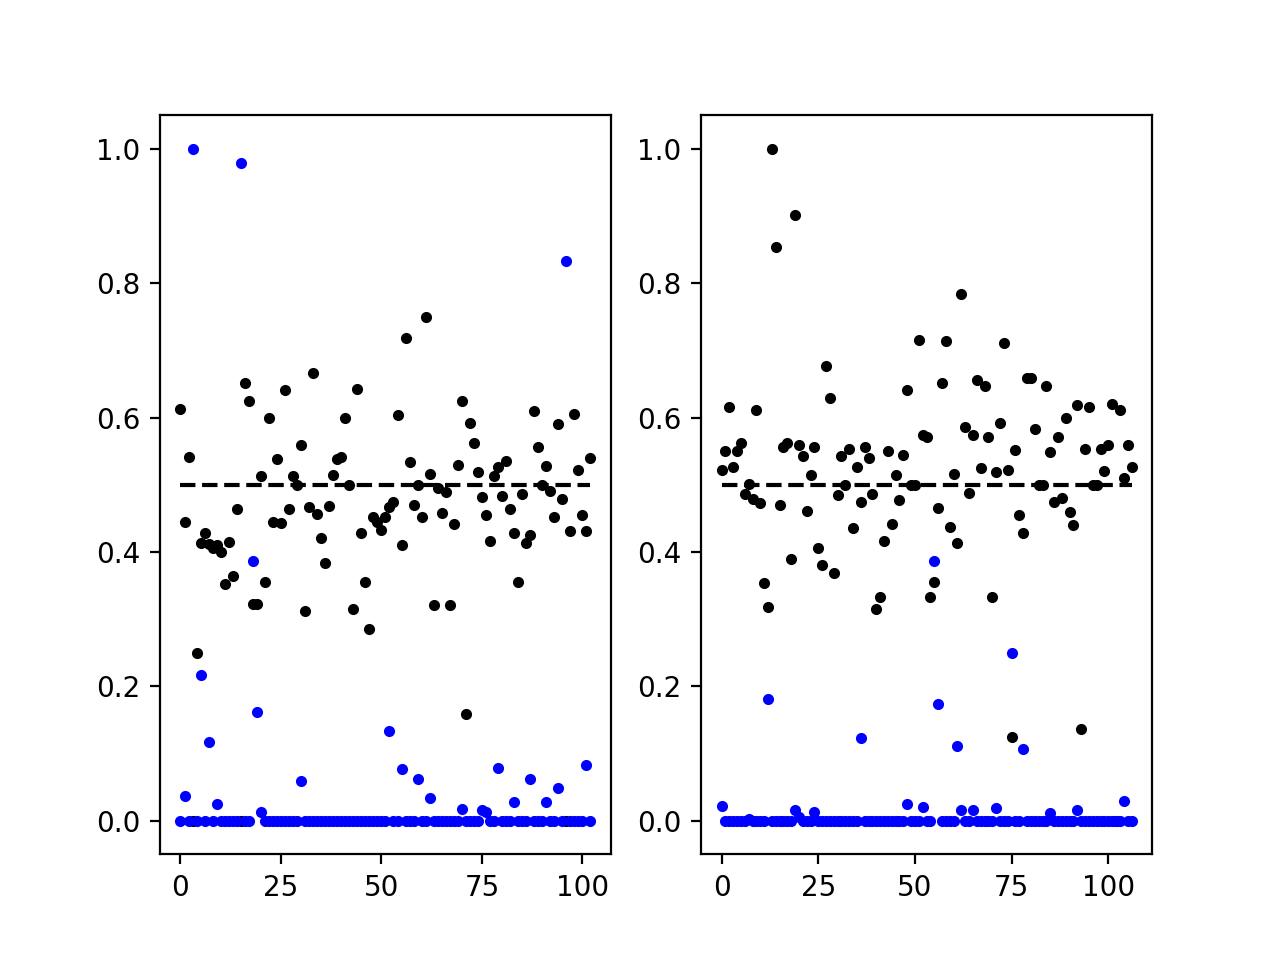

<IPython.core.display.Javascript object>


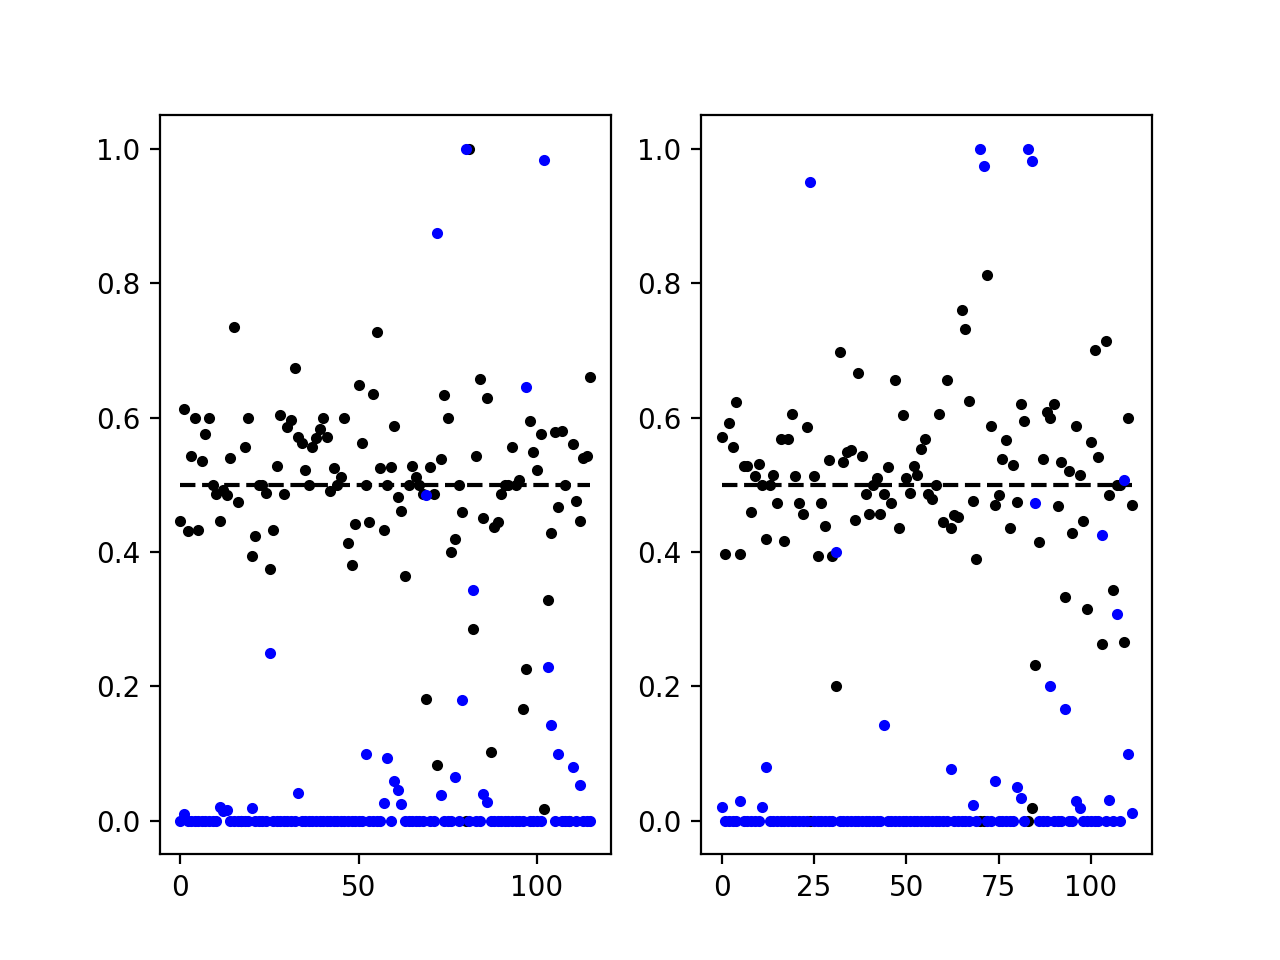

In [4]:

for set in sets :
    
    f , axarr = plt.subplots( 1 , len(set['labels']) )
    c = 0 
    
    for l in set["labels"] : 
        
        df = pd.read_csv( "%s/wikisurvey_%s_ready_withskip.csv" % (datadir,l) )
        
        idf = df.groupby( ['Session ID','Winner'] )['Left Choice ID'].count().reset_index()
        
        def leftagg( series ) : 
            return np.sum( series ==  1 )
        def nochagg( series ) : 
            return np.sum( series ==  0 )
        def rightagg( series ) : 
            return np.sum( series == -1 )
            
        fdf = pd.DataFrame( df.groupby( ['Session ID'] )['Winner'].count() )
        fdf.columns = ['Total']
        fdf['Left'] = df.groupby( ['Session ID'] ).agg( { 'Winner' : leftagg  } )
        fdf['No Choice'] = df.groupby( ['Session ID'] ).agg( { 'Winner' : nochagg  } )
        fdf['Right'] = df.groupby( ['Session ID'] ).agg( { 'Winner' : rightagg } )
    
        inds = fdf.index.values
        axarr[c].plot( inds , 0.5 * np.ones( inds.shape ) , '--k' )
        axarr[c].plot( inds , ( fdf['Left'] / fdf['Total'] ).values , '.k' )
        axarr[c].plot( inds , ( fdf['No Choice'] / fdf['Total'] ).values , '.b' )
        
        c += 1

### Empirical Win Frequency/Fractions

Here we compute the "EWF"s, just to make sure they aren't "trival" in some way that would inhibit meaningful analysis. 

In [5]:

for set in sets :
    
    for l in set["labels"] : 
        
        df = pd.read_csv( "%s/wikisurvey_%s_ready_withskip.csv" % (datadir,l) )
        
        A = df['Left Choice ID'].max() + 1
        rdf = pd.DataFrame( np.zeros( ( A , 4 ) ) , 
                               index=np.arange(0,A,1) + 1 , 
                               columns=[ 'Left Appearances' , 'Right Appearances' , 'Appearances' , 'Emp Win Freq' ] )
        rdf['Left Appearances']  = df.groupby( 'Left Choice ID' )['Winner'].count().values
        rdf['Right Appearances'] = df.groupby( 'Right Choice ID' )['Winner'].count().values
        rdf['Appearances'] = rdf['Left Appearances'] + rdf['Right Appearances']
        
        df = pd.read_csv( "%s/wikisurvey_%s_ready_noskip.csv" % (datadir,l) )
        
        df['Winner ID'] = df['Left Choice ID'] * ( df['Winner'] + 1 ) / 2 \
                              + df['Right Choice ID'] * ( 1 - df['Winner'] ) / 2 + 1
        
        rdf['Winner'] = df.groupby( 'Winner ID' )['Winner'].count()
        rdf['Emp Win Freq'] = rdf['Winner'] / rdf['Appearances']
        
        ewf = rdf['Emp Win Freq'].sort_values( ascending=False )
        print( ewf , ewf.loc[6] )
        

6     0.693878
23    0.638614
22    0.624703
17    0.620047
20    0.593220
16    0.586207
4     0.585082
15    0.579208
2     0.567198
3     0.525060
21    0.506203
8     0.458115
13    0.439086
5     0.438725
9     0.432127
14    0.408257
18    0.399543
1     0.399516
12    0.393519
7     0.366492
11    0.327411
19    0.265363
10    0.262009
Name: Emp Win Freq, dtype: float64 0.6938775510204082
23    0.645455
22    0.640449
17    0.631915
20    0.617063
6     0.614679
15    0.612832
16    0.601293
2     0.586907
3     0.538976
4     0.485437
21    0.465812
1     0.464286
9     0.459402
18    0.446541
8     0.445887
7     0.430928
14    0.429204
12    0.410148
5     0.393407
13    0.380846
11    0.365957
10    0.336910
19    0.328859
Name: Emp Win Freq, dtype: float64 0.6146788990825688
12    0.616698
5     0.594041
10    0.587687
1     0.579961
18    0.570020
7     0.563601
9     0.549898
6     0.548936
17    0.533195
4     0.515770
11    0.513684
16    0.505682
15    0.503937
14    0

### Data "Quality"

Here we (qualitatively) assess at least one aspect of data quality: uniformity of samples across pairs of alternatives in each of the four experiments. 

<IPython.core.display.Javascript object>


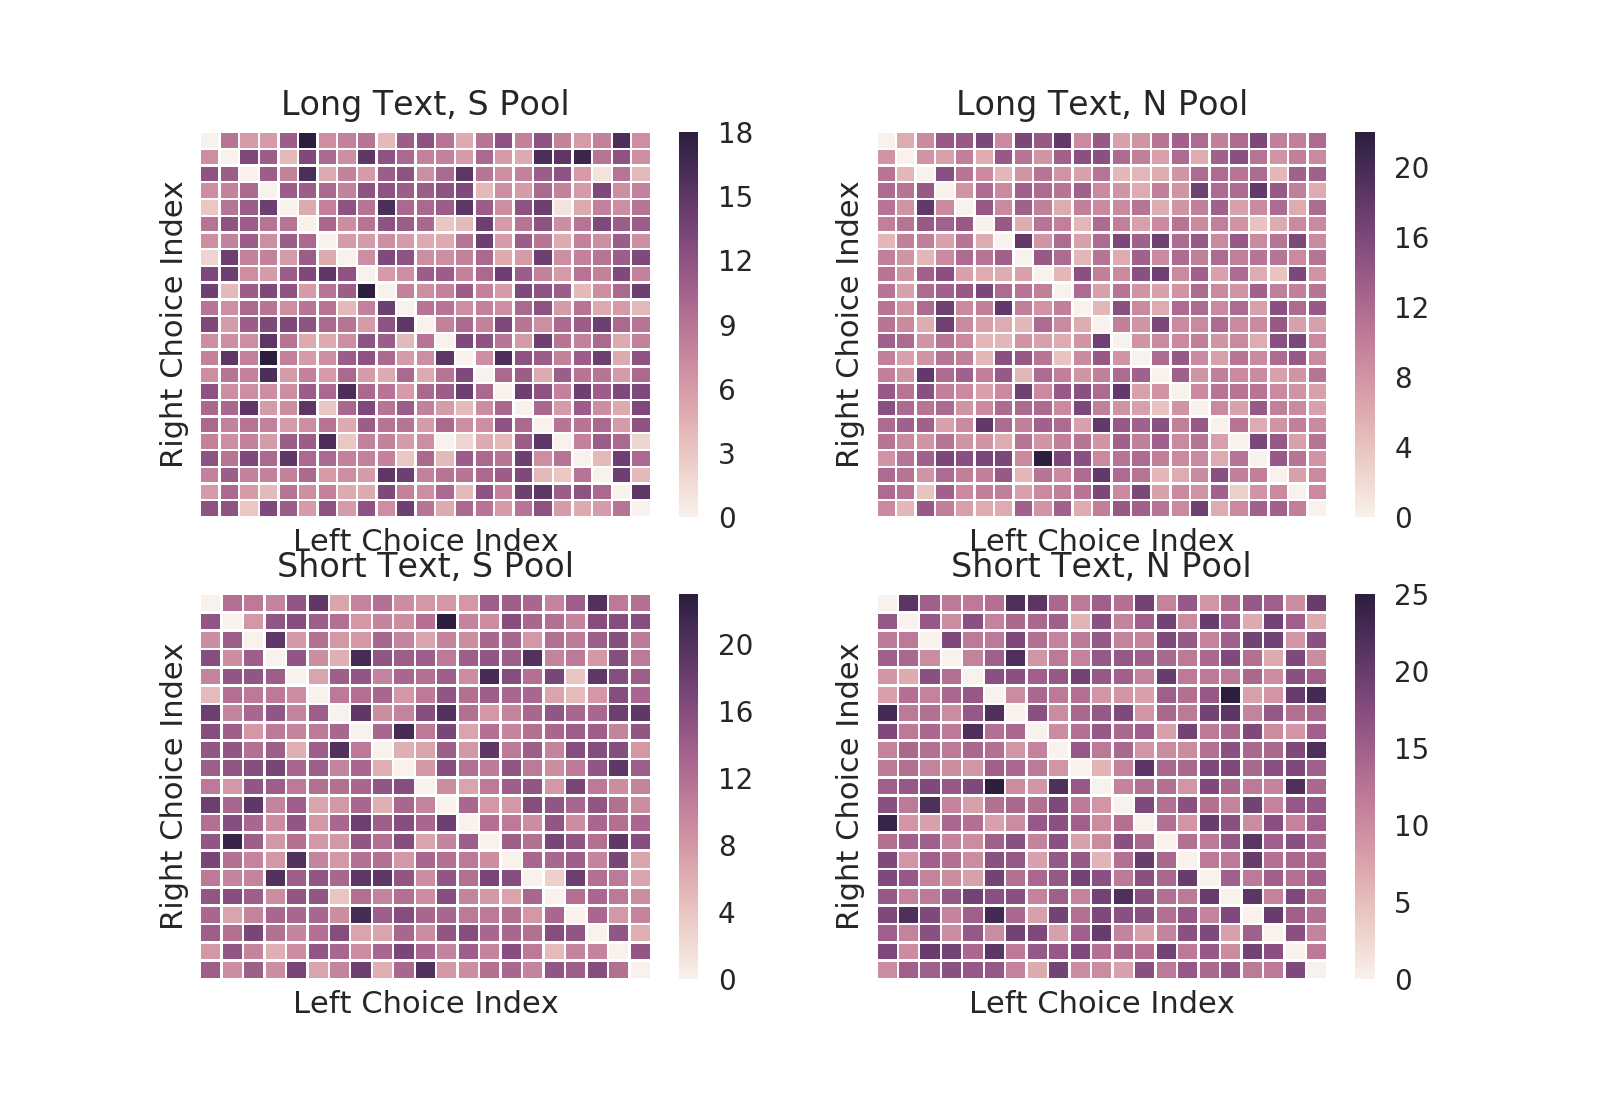

In [6]:

import seaborn as sns

plt.figure()
p = 1
for set in sets :
    
    for l in set["labels"] : 
        
        df = pd.read_csv( "%s/wikisurvey_%s_ready.csv" % (datadir,l) )
        
        plt.subplot( len(sets) , len(set["labels"]) , p )
        
        hm = df.groupby( ['Left Choice ID','Right Choice ID'] )['Left Won'].count().reset_index()
        hmd = coo_matrix( (hm['Left Won'].values,(hm['Left Choice ID'].values,hm['Right Choice ID'].values)) ).toarray()
        ax = sns.heatmap( hmd , linewidth=0.5 , xticklabels=False , yticklabels=False )
        ax.set(xlabel='Left Choice Index', ylabel='Right Choice Index')
        ax.set(title=('%s' % (set['titles'][l])) )
        
        p += 1

# erase seaborn changes to formatting after plotting the heatmap
mpl.rc_file_defaults()

# Estimation Success Rate

The plot below shows the estimation success rate for each survey (12318, 12319, 12383, and 12384). `cvxpy` comes built with a single solver (AFAIK) to solve this sort of problem (an exponential cone problem): [ECOS](http://stanford.edu/~boyd/papers/ecos.html). Except for small values of $\Lambda$ (say $\lt 10^{-2}$), the estimation always succeeds. 

Note that, so far, _we do not exclude failed runs in our analyses below_. 

<IPython.core.display.Javascript object>


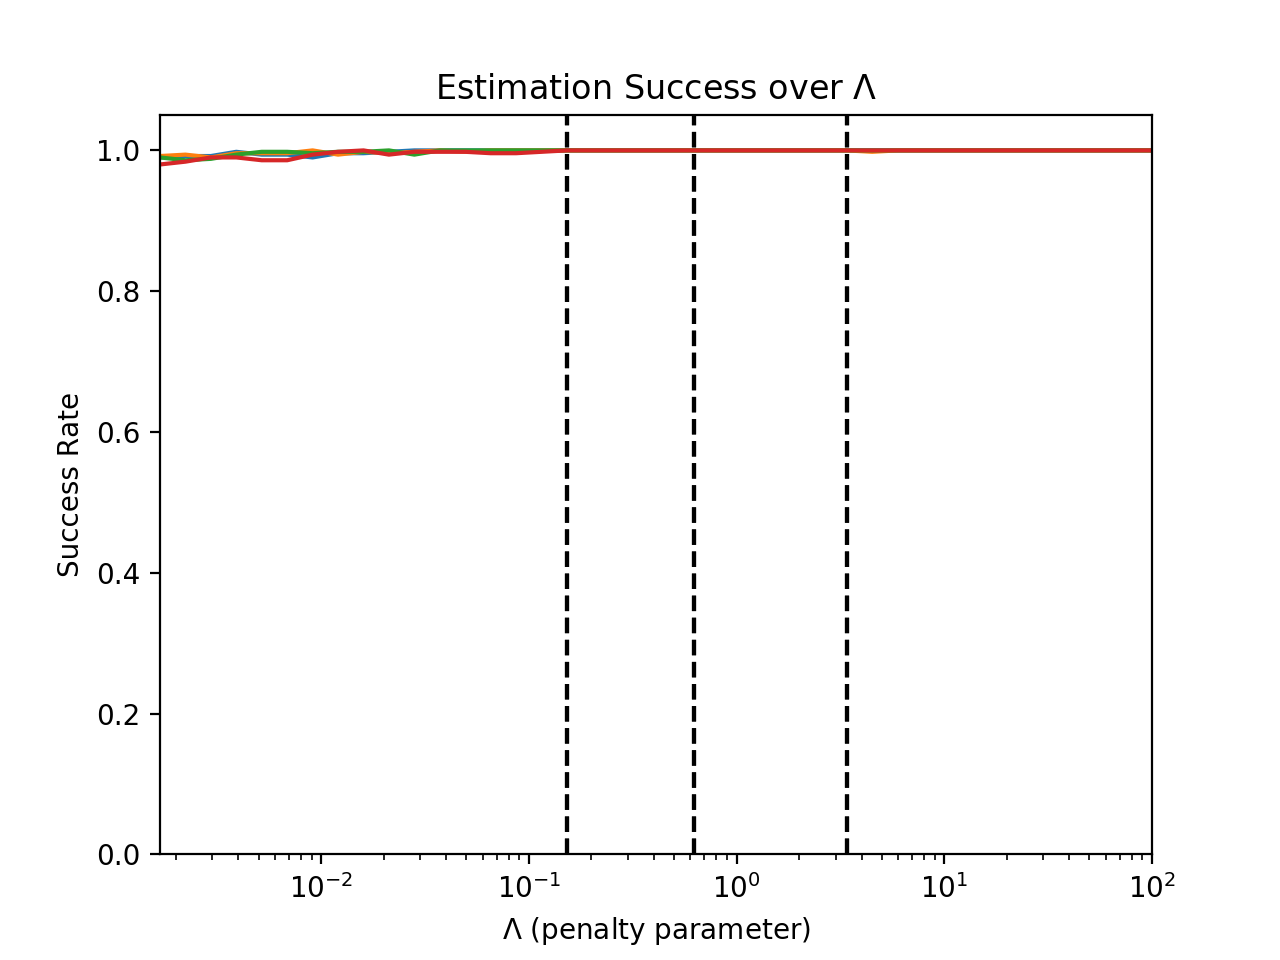

In [7]:
plt.figure()
for set in sets :
    for l in set["labels"] : 
        count , sccss = 0 , np.zeros( T )
        for s in range(0,S) : 
            try : 
                sccss = sccss + np.fromfile( "%s/bootstrap/%s/success-%i.bin" % (resdir,l,s) , dtype=np.int )
                count += 1
            except FileNotFoundError as e : 
                print( e )
        plt.semilogx( lambdas[:minlam] , sccss[:minlam] / count )  
    for l in lfix : 
        plt.semilogx( lambdas[[l,l]] , [0,1.05] , '--k' ) 
    plt.axis( [lambdas[:minlam].min(),lambdas[:minlam].max(),0,1.05] )
    plt.title( 'Estimation Success over $\Lambda$' )
    plt.xlabel( '$\Lambda$ (penalty parameter)' )
    plt.ylabel( 'Success Rate' )

# Optimal Likelihood

The following code creates the plots below, showing the optimal likelihood of observing the data with an `idLogit` model. The solid black lines show the 5% and 95% envelope over the 500 bootstrap samples (90% optimal likelihoods lie within these bounds) for each $\Lambda$. The dashed line shows the mean likelihood for each $\Lambda$. The dots show the mean $\pm$ one standard deviation. 

Overall, for reasonable values of $\Lambda$, the likelihood envelopes are very tight around the mean. However the data and underlying models are changing across bootstrap samples, they are not changing the optimal likelihood much. 

These results suggest to me that between, roughly, $\Lambda = 0.3$ and $\Lambda = 2$ we are seeing the majority of beneficial effects from including deviations. 

<IPython.core.display.Javascript object>


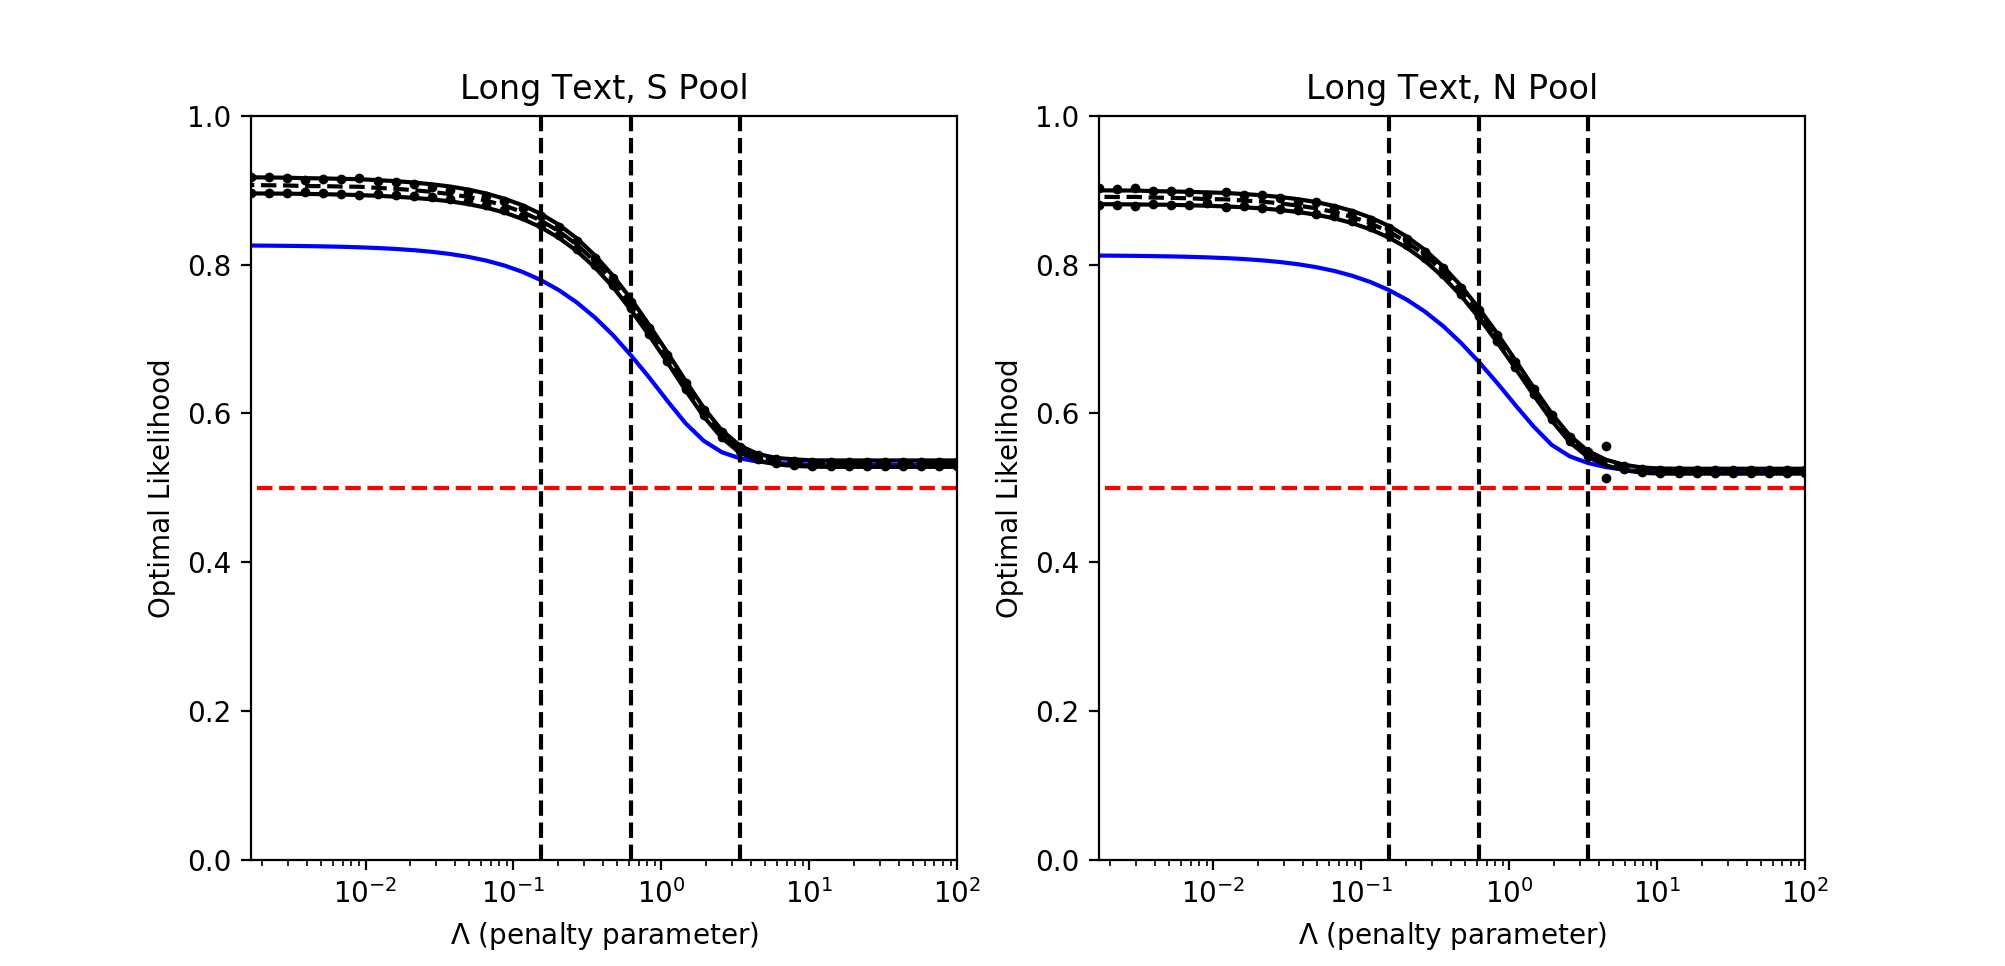

<IPython.core.display.Javascript object>


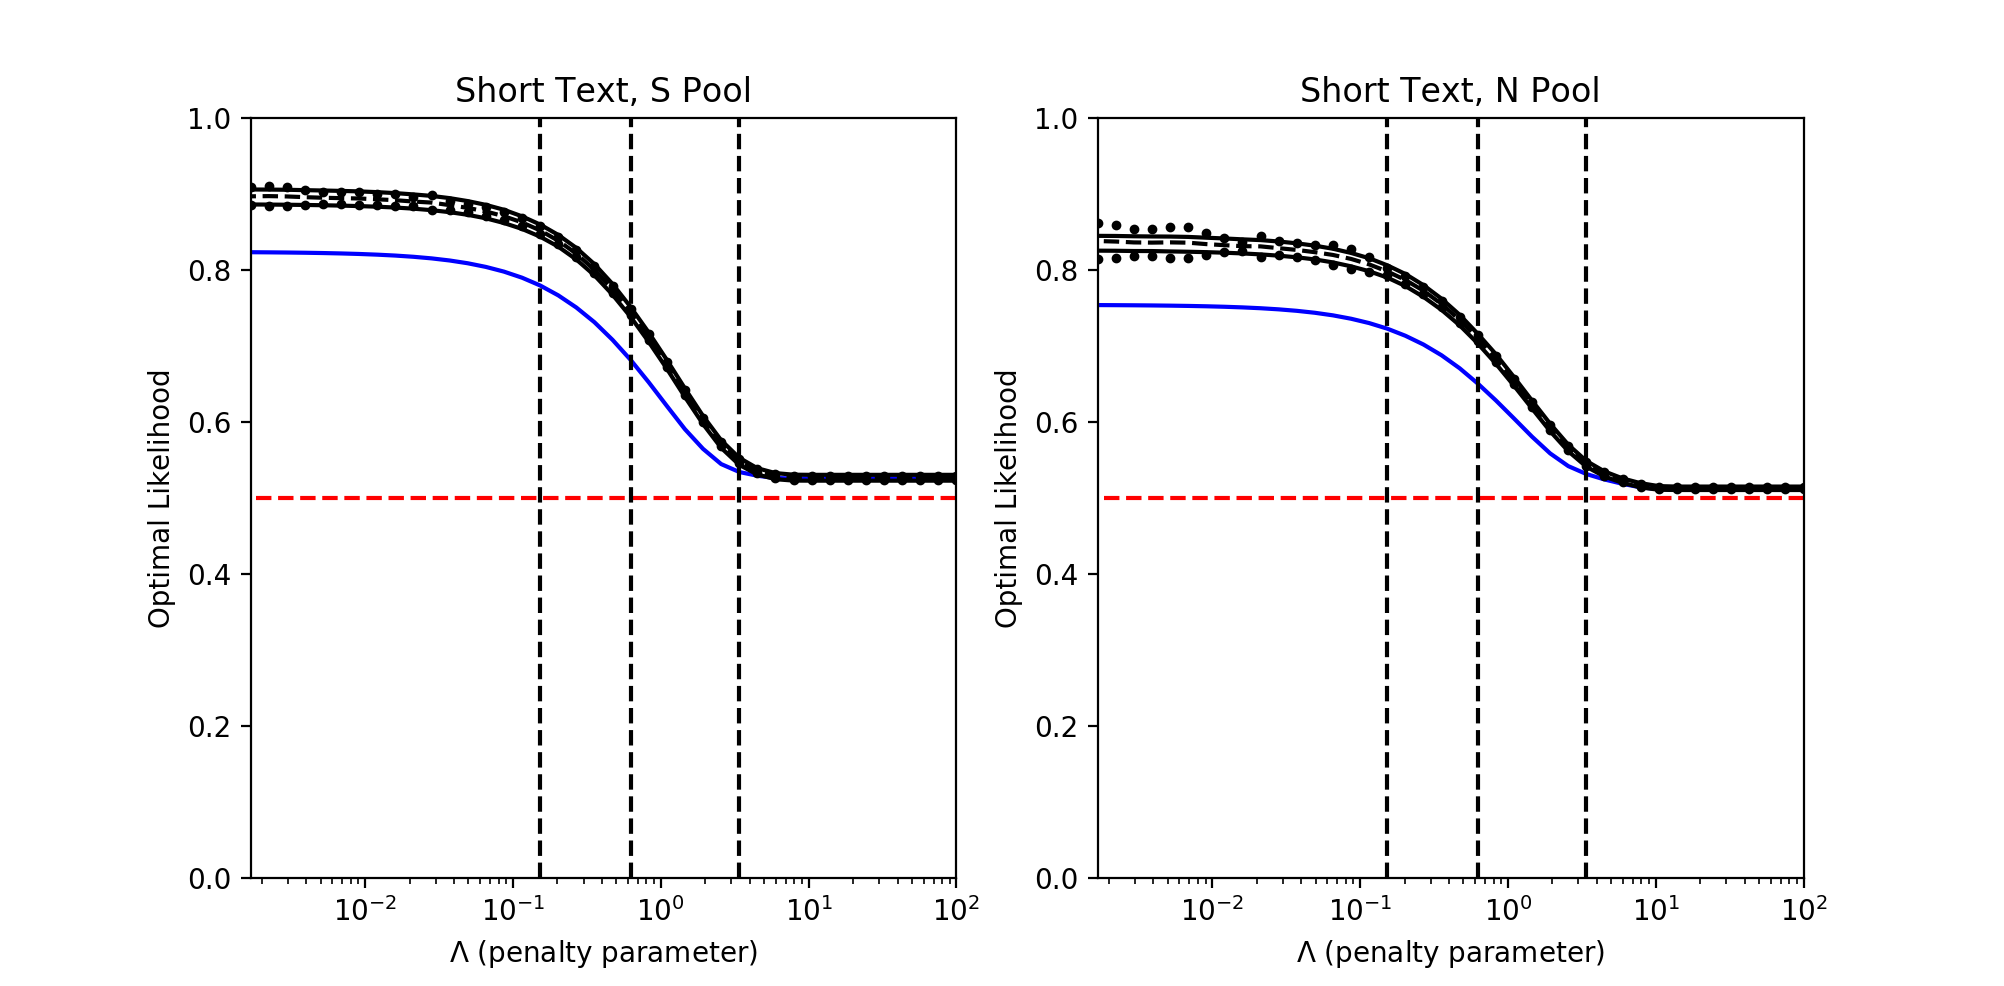

In [8]:
for set in sets : 
    
    f , axarr = plt.subplots( 1 , len(set["labels"]) )
    p = 0
    
    for l in set["labels"] : 
        
        act_likli = np.exp( np.fromfile( "%s/actual/%s/loglk.bin" % (resdir,l) ).reshape( (T) ) )
    
        count , loglk = 0 , np.zeros( (S,T) )
        for s in range(0,S) : 
            try : 
                loglk[s,:] = np.fromfile( "%s/bootstrap/%s/loglk-%i.bin" % (resdir,l,s) ).reshape( (T) )
                count += 1
            except FileNotFoundError as e : 
                print( e )
                pass
        

        likli = np.exp( loglk[0:count,:] )

        m , s , slik = likli.mean( axis=0 ) , likli.std( axis=0 ) , np.sort( likli , axis=0 )
        lower = np.int( np.floor( 0.05 * slik.shape[0] ) )
        upper = np.int( np.ceil( 0.95 * slik.shape[0] ) )
        
        
        axarr[p].semilogx( lambdas[:minlam] , 0.5 * np.ones( minlam ) , '--r' )
        
        axarr[p].semilogx( lambdas[:minlam] , act_likli[:minlam] , '-b' )
        
        axarr[p].semilogx( lambdas[:minlam] , slik[upper,:minlam] , '-k' )
        axarr[p].semilogx( lambdas[:minlam] , m[:minlam] + s[:minlam] , '.k' , Markersize=5 )
        axarr[p].semilogx( lambdas[:minlam] , m[:minlam] , '--k' )
        axarr[p].semilogx( lambdas[:minlam] , m[:minlam] - s[:minlam] , '.k' , Markersize=5 )
        axarr[p].semilogx( lambdas[:minlam] , slik[lower,:minlam] , '-k' )
        axarr[p].semilogx( lambdas[[lfix[0],lfix[0]]] , [0,1] , '--k' )
        axarr[p].semilogx( lambdas[[lfix[1],lfix[1]]] , [0,1] , '--k' )
        axarr[p].semilogx( lambdas[[lfix[2],lfix[2]]] , [0,1] , '--k' )
        axarr[p].axis( [lambdas[:minlam].min(),lambdas[:minlam].max(),0,1.0] )
        axarr[p].set_title( '%s' % (set['titles'][l]) )
        axarr[p].set_xlabel( '$\Lambda$ (penalty parameter)' )
        axarr[p].set_ylabel( 'Optimal Likelihood' )
        
        p += 1
        

<IPython.core.display.Javascript object>


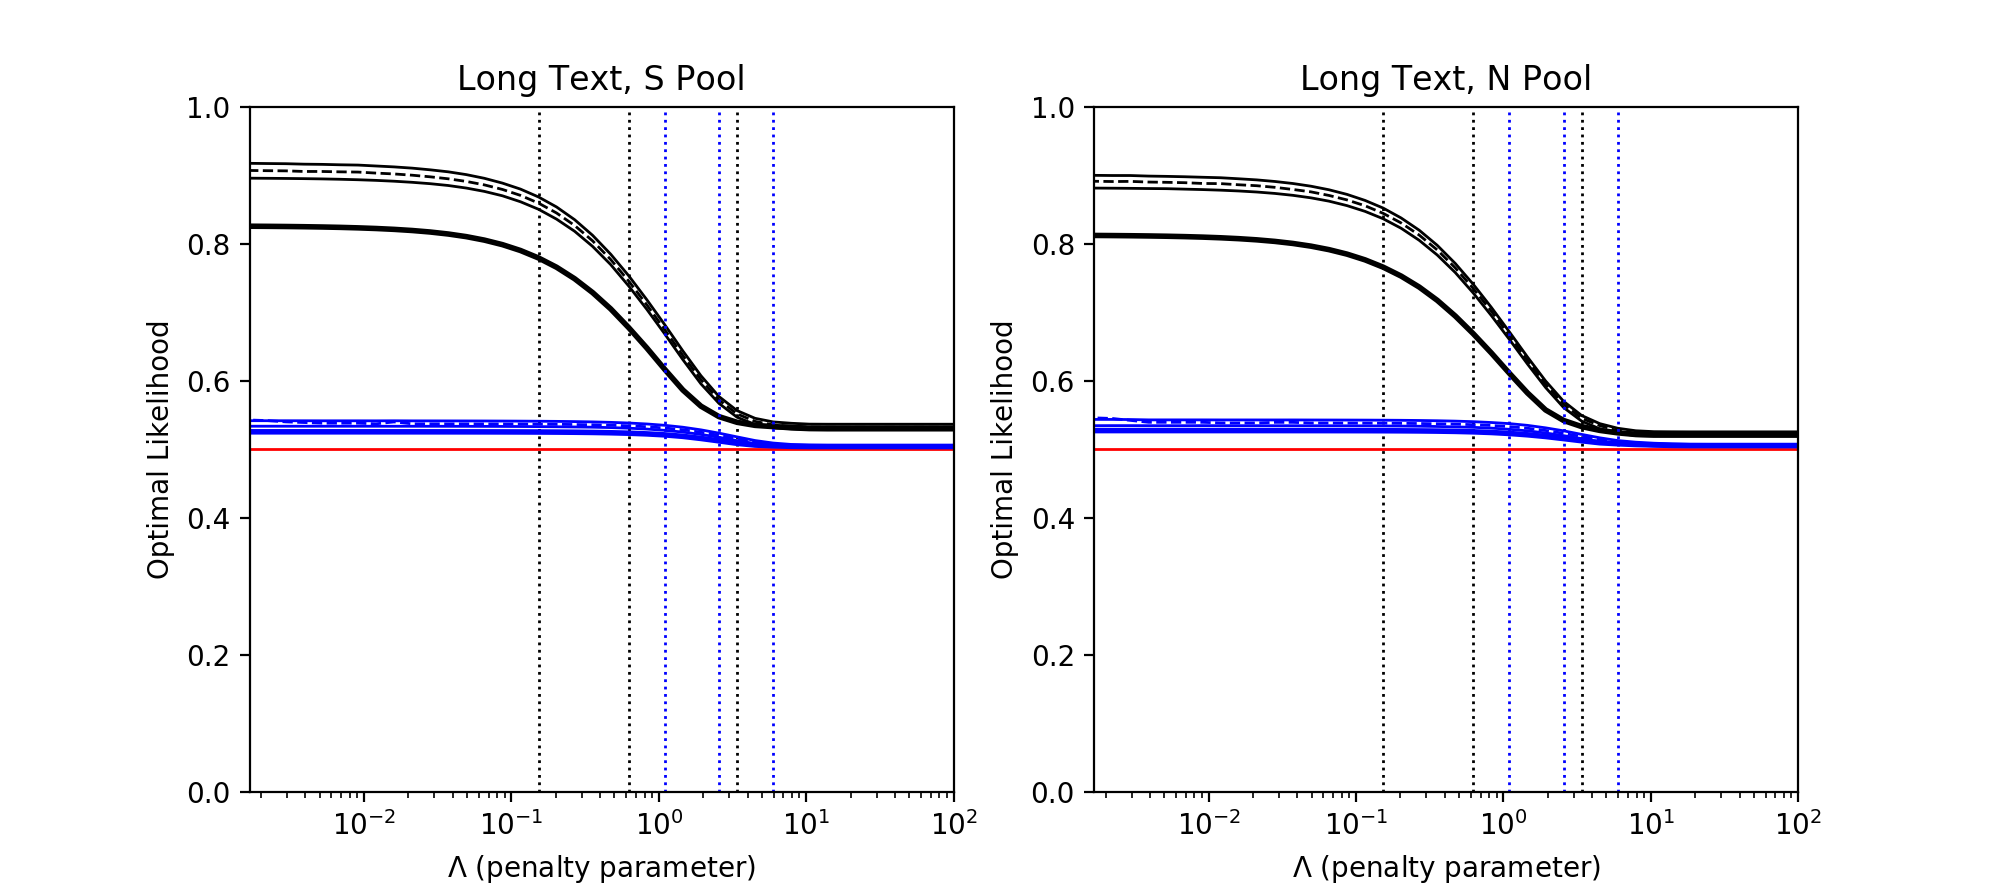

<IPython.core.display.Javascript object>


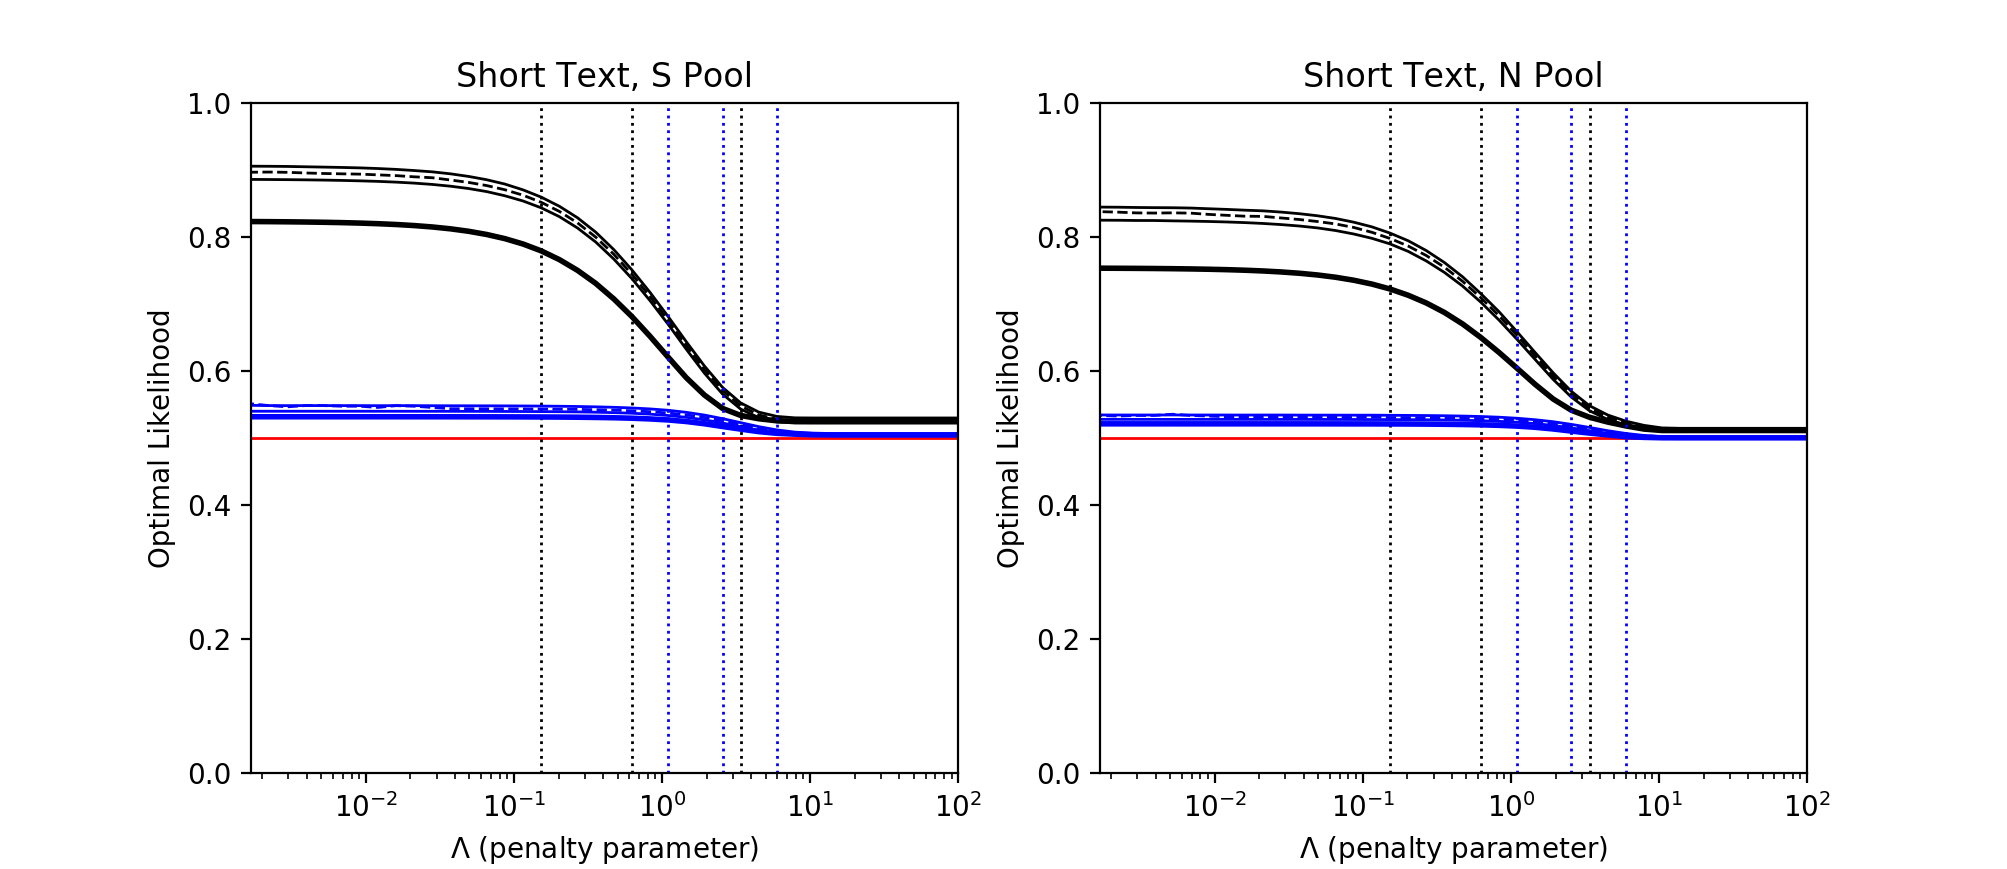

In [9]:

for set in sets : 
    
    f , axarr = plt.subplots( 1 , len(set["labels"]) )
    p = 0
    
    for l in set["labels"] : 
        
        # null model line
        axarr[p].semilogx( [lambdas[:minlam].min(),lambdas[:minlam].max()] , [0.5,0.5] , '-r' , Linewidth=1 )
    
        count , ie_count , loglk , ie_loglk = 0 , 0 , np.zeros( (S,T) ) , np.zeros( (S,T) )
        for s in range(0,S) : 
            try : 
                loglk[s,:] = np.fromfile( "%s/bootstrap/%s/loglk-%i.bin" % (resdir,l,s) ).reshape( (T) )
                count += 1
                ie_loglk[s,:] = np.fromfile( "%s/bootstrap/%s/loglk-%i.bin" % (ie_resdir,l,s) ).reshape( (T) )
                ie_count += 1
            except FileNotFoundError as e : 
                print( e )
                pass

        likli = np.exp( loglk[0:count,:] )

        m , s , slik = likli.mean( axis=0 ) , likli.std( axis=0 ) , np.sort( likli , axis=0 )
        lower = np.int( np.floor( 0.05 * slik.shape[0] ) )
        upper = np.int( np.ceil( 0.95 * slik.shape[0] ) )
        
        axarr[p].semilogx( lambdas[:minlam] , slik[upper,:minlam] , '-k' , Linewidth=1 )
        axarr[p].semilogx( lambdas[:minlam] , m[:minlam] , '--k' , Linewidth=1 )
        axarr[p].semilogx( lambdas[:minlam] , slik[lower,:minlam] , '-k' , Linewidth=1 )
        
        for lf in range(0,3) : 
            axarr[p].semilogx( lambdas[[lfix[lf],lfix[lf]]] , [0,1] , ':k' , Linewidth=1 )
        
        
        loglk[0,:] = np.fromfile( "%s/actual/%s/loglk.bin" % (resdir,l) ).reshape( (T) )
        likli = np.exp( loglk[0,:] )
        axarr[p].semilogx( lambdas[:minlam] , likli[:minlam] , '-k' , Linewidth=2 )
        
        
        likli = np.exp( ie_loglk[0:count,:] )

        m , s , slik = likli.mean( axis=0 ) , likli.std( axis=0 ) , np.sort( likli , axis=0 )
        lower = np.int( np.floor( 0.05 * slik.shape[0] ) )
        upper = np.int( np.ceil( 0.95 * slik.shape[0] ) )
        
        axarr[p].semilogx( lambdas[:minlam] , slik[upper,:minlam] , '-b', Linewidth=1 )
        axarr[p].semilogx( lambdas[:minlam] , m[:minlam] , '--b' , Linewidth=1 )
        axarr[p].semilogx( lambdas[:minlam] , slik[lower,:minlam] , '-b' , Linewidth=1 )
        
        for lf in range(0,3) : 
            axarr[p].semilogx( lambdas[[ie_lfix[lf],ie_lfix[lf]]] , [0,1] , ':b' , Linewidth=1 )
        
        loglk[0,:] = np.fromfile( "%s/actual/%s/loglk.bin" % (ie_resdir,l) ).reshape( (T) )
        likli = np.exp( loglk[0,:] )
        axarr[p].semilogx( lambdas[:minlam] , likli[:minlam] , '-b' , Linewidth=2 )
        
        axarr[p].axis( [lambdas[:minlam].min(),lambdas[:minlam].max(),0,1.0] )
        axarr[p].set_title( '%s' % (set['titles'][l]) )
        axarr[p].set_xlabel( '$\Lambda$ (penalty parameter)' )
        axarr[p].set_ylabel( 'Optimal Likelihood' )
        
        
        p += 1
        
    
        

We should probably look at the influence of the number of parameters on likelihood. 

<IPython.core.display.Javascript object>


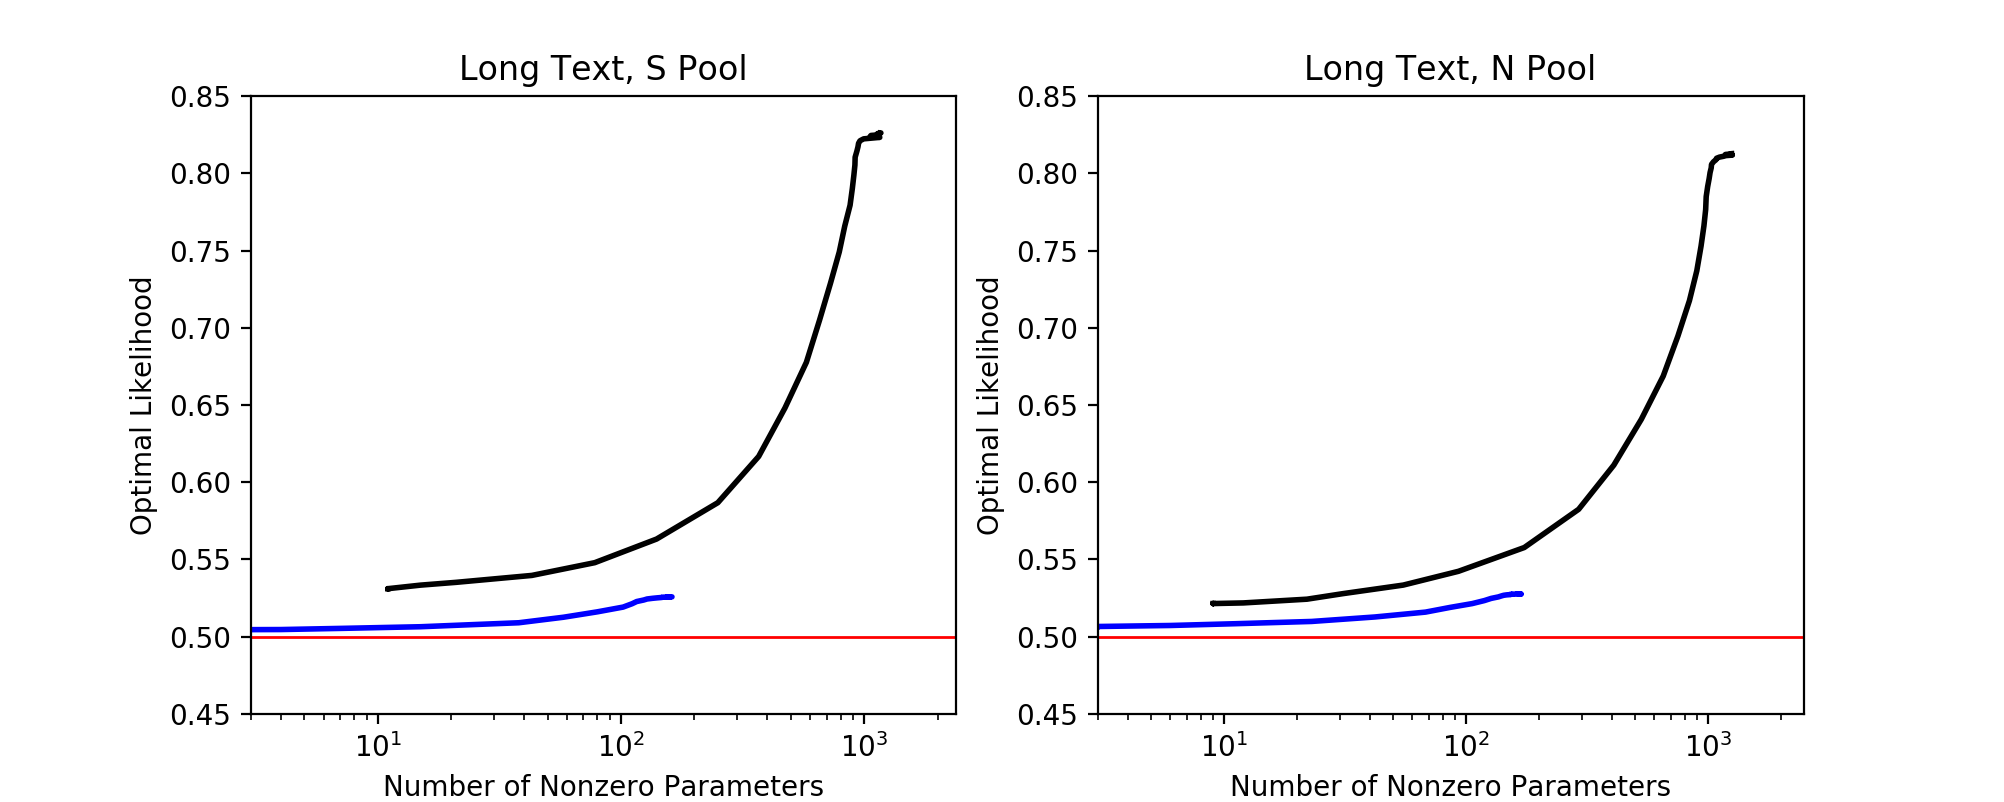

<IPython.core.display.Javascript object>


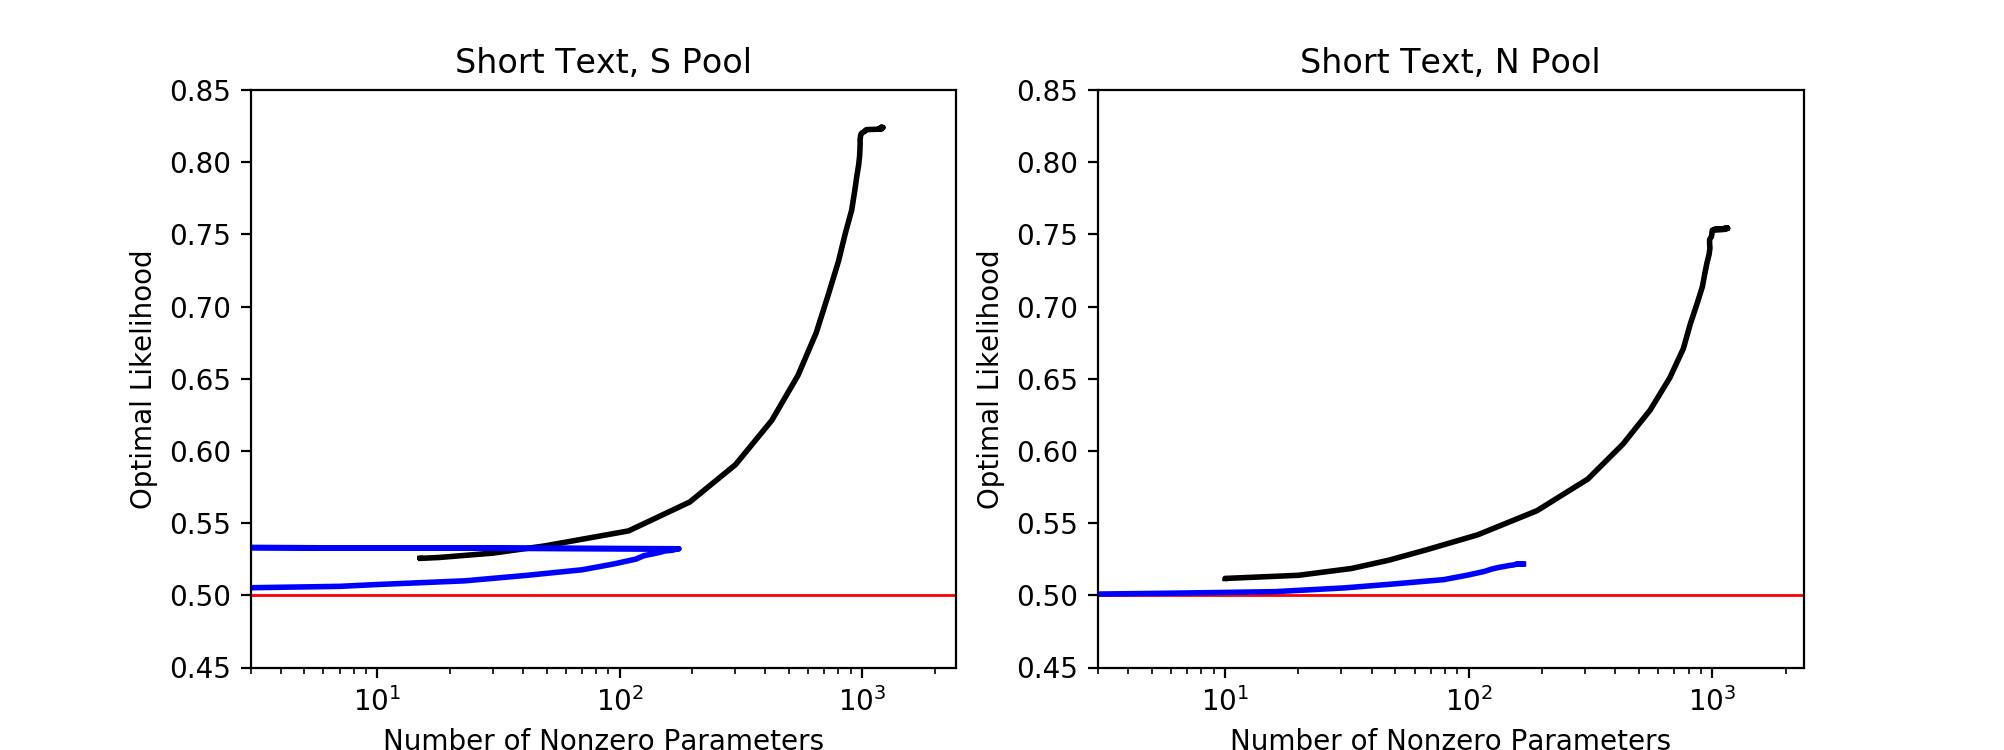

In [10]:

for set in sets : 
    
    f , axarr = plt.subplots( 1 , len(set["labels"]) )
    p = 0
    
    for l in set["labels"] : 
    
        loglk = np.fromfile( "%s/actual/%s/loglk.bin" % (resdir,l) ).reshape( (T) )
        betas = np.fromfile( "%s/actual/%s/betas.bin" % (resdir,l) )
        delta = np.fromfile( "%s/actual/%s/delta.bin" % (resdir,l) )
        A = np.int( betas.shape[0] / T )
        I = np.int( delta.shape[0] / (A*T) )
        betas = betas.reshape( (A,T) )
        delta = delta.reshape( (I*A,T) )
        nonzero = np.sum( betas > 1.0e-6 , axis=0 ) + np.sum( delta > 1.0e-6 , axis=0 )
        
        axarr[p].semilogx( nonzero , np.exp(loglk) , '-k' , Linewidth=2 )
        
        loglk = np.fromfile( "%s/actual/%s/loglk.bin" % (ie_resdir,l) ).reshape( (T) )
        betas = np.fromfile( "%s/actual/%s/betas.bin" % (ie_resdir,l) )
        delta = np.fromfile( "%s/actual/%s/delta.bin" % (ie_resdir,l) )
        Aie = np.int( betas.shape[0] / T )
        Iie = np.int( delta.shape[0] / (Aie*T) )
        betas = betas.reshape( (Aie,T) )
        delta = delta.reshape( (Iie*Aie,T) )
        nonzero = np.sum( betas > 1.0e-6 , axis=0 ) + np.sum( delta > 1.0e-6 , axis=0 )
        
        axarr[p].semilogx( [Aie,(I+1)*A] , [0.5,0.5] , '-r' , Linewidth=1 )
        axarr[p].semilogx( nonzero , np.exp(loglk) , '-b' , Linewidth=2 )
        
        
        axarr[p].axis( [Aie,(I+1)*A,0.45,0.85] )
        axarr[p].set_title( '%s' % (set['titles'][l]) )
        axarr[p].set_xlabel( 'Number of Nonzero Parameters' )
        axarr[p].set_ylabel( 'Optimal Likelihood' )
        
        p += 1
        

# Shared Opinions

We can capture the the $\beta$ coefficients, as well as their variation. We can do alot better than the plot below, which isn;'t particularly meaningful. To do so probably need to zero in on a few particular penalty parameter ($\Lambda$) values. In any case, this is a "standard" sort of plot for the `LASSO`/`L1`/Sparse regression field. 

<IPython.core.display.Javascript object>


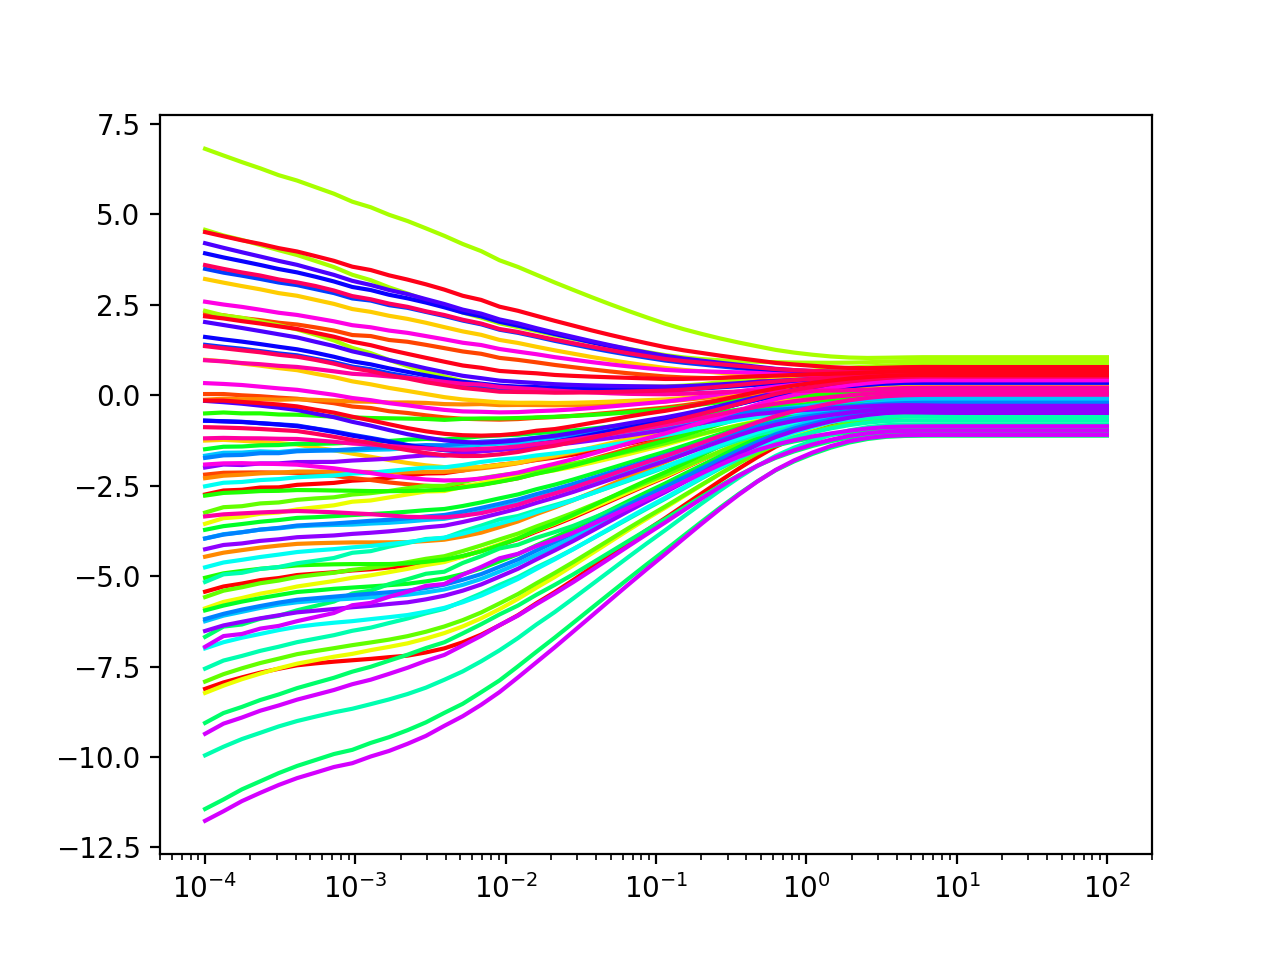

<IPython.core.display.Javascript object>


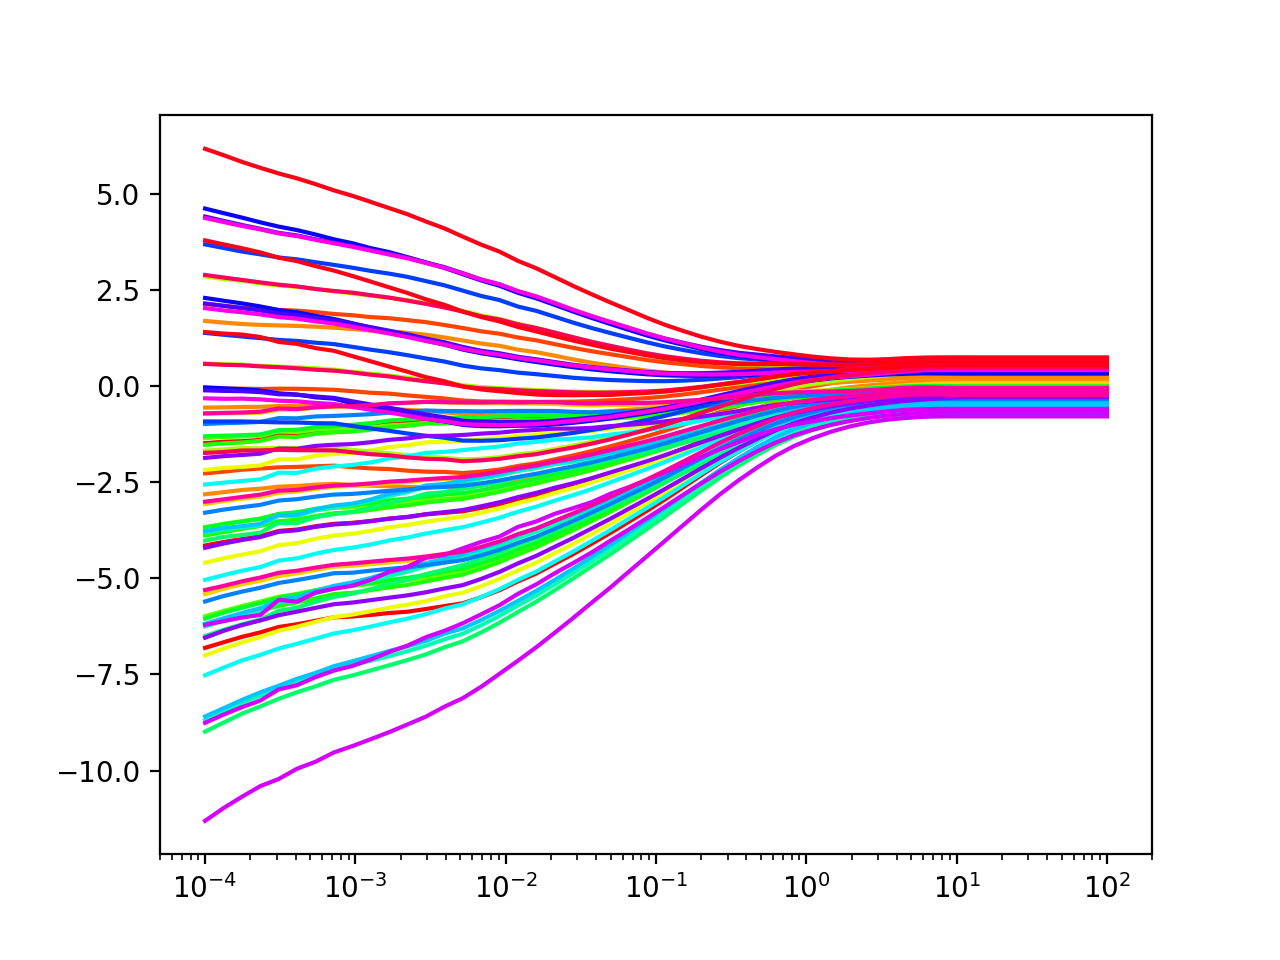

<IPython.core.display.Javascript object>


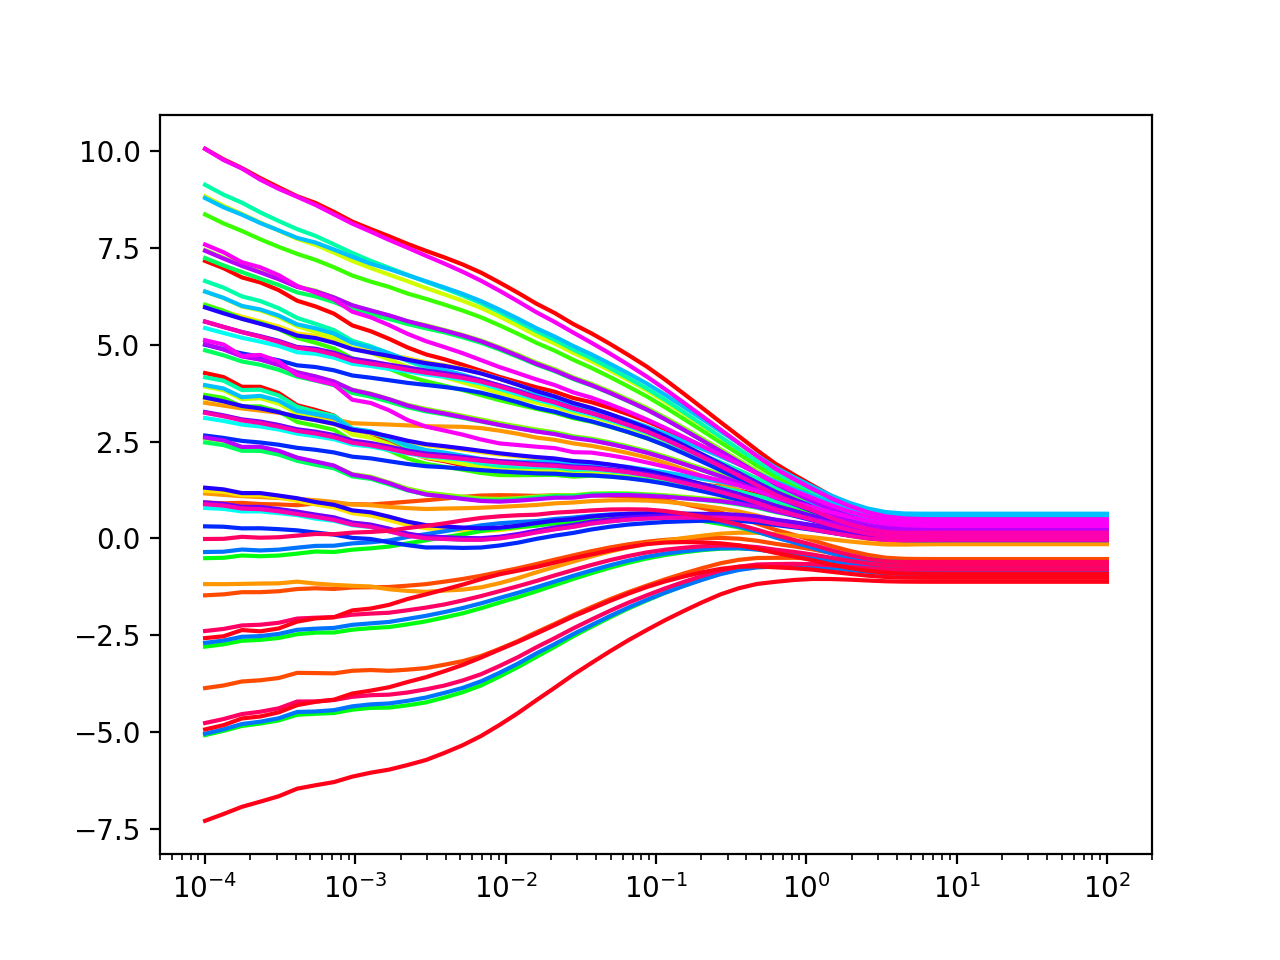

<IPython.core.display.Javascript object>


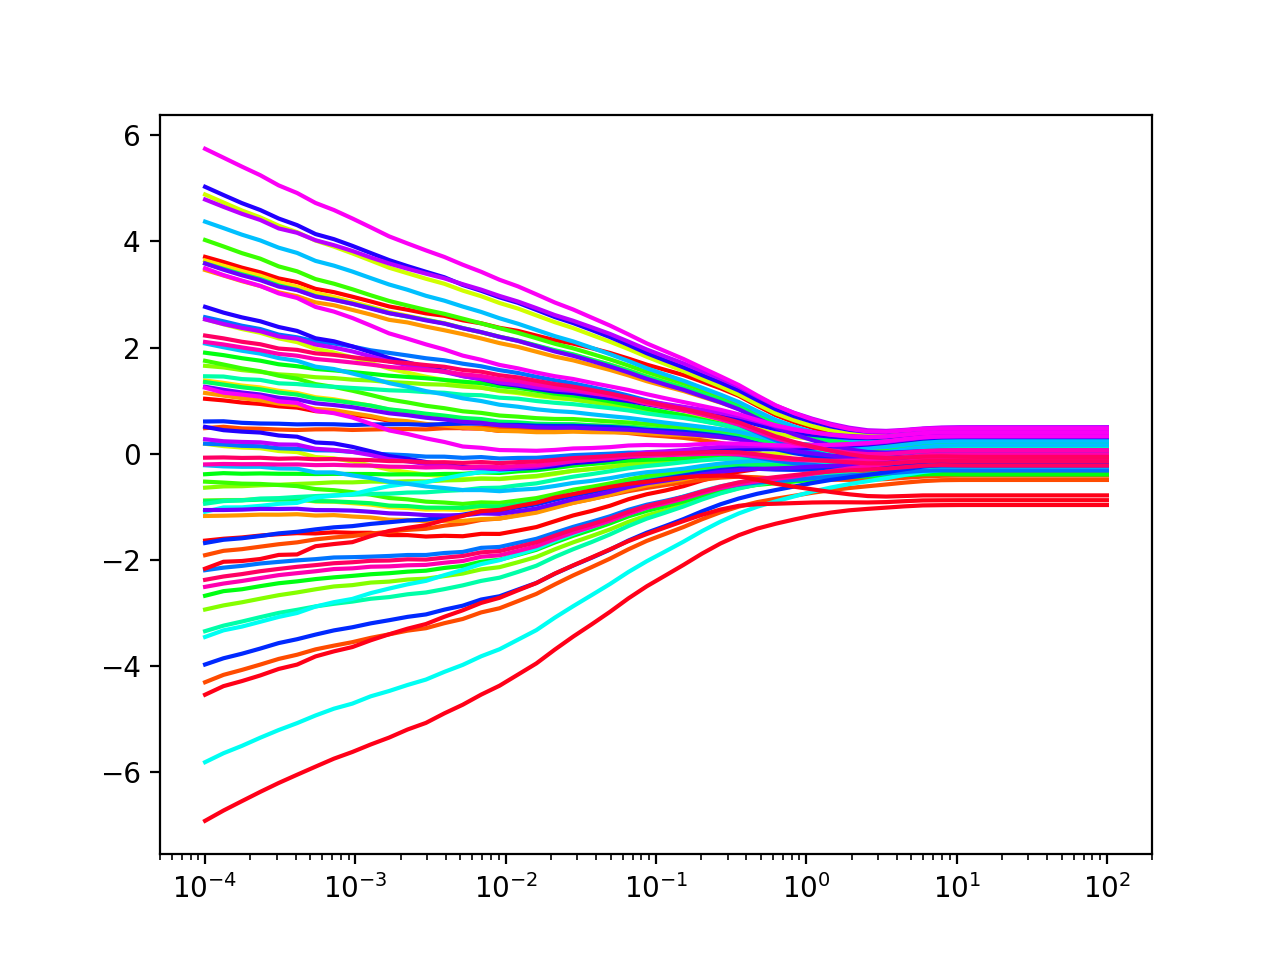

In [11]:
def get_cmap( n , name='hsv' ) :
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap( name , n )

for set in sets :
    
    for l in set["labels"] : 
    
        A , count = None , 0

        for s in range(0,S) : 
            try : 
                betas = np.fromfile( "%s/bootstrap/%s/betas-%i.bin" % (resdir,l,s) )
                if A is None : 
                    A = np.int( betas.shape[0] / T )
                    allbetas = np.zeros( (A,T,S) )
                allbetas[:,:,s] = betas.reshape( (A,T) )
                count += 1
            except FileNotFoundError as e : 
                pass

        bu , bm , bs , bl = np.zeros( (A,T) ) , np.zeros( (A,T) ) , np.zeros( (A,T) ) , np.zeros( (A,T) )
        for a in range(0,A) : 
            for t in range(0,T) : 
                bm[a,t] = np.mean( allbetas[a,t,:] )
                bs[a,t] = np.std( allbetas[a,t,:] )
                allbetas[a,t,:] = np.sort( allbetas[a,t,:] )
                lower = np.int( np.floor( 0.05 * count ) )
                upper = np.int( np.ceil( 0.95 * count ) )
                bl[a,t] = allbetas[a,t,lower]
                bu[a,t] = allbetas[a,t,upper]

        plt.figure()
        color = get_cmap( A )
        for a in range(0,A) : 
            plt.semilogx( lambdas , bm[a,:] , c=color(a) )
            plt.semilogx( lambdas , bm[a,:] + bs[a,:] , c=color(a) )
            plt.semilogx( lambdas , bm[a,:] - bs[a,:] , c=color(a) )

# Alternative Rankings

The code below of subsequent plots show the probability an alternative is judged as "most" or "least" authentic. For the `idLogit` model, this judgement is simply which $\beta$ coefficient is largest ("most") or smallest ("least"). While we do not label the plots with the alternative numbers, we do write out CSV (Excel) files with the probability each alternative is judged as most/least authentic for each $\Lambda$ ("on average" over the respondent population). 

It is possible to compute a complete probability distribution over the rank of each alternative. 

What is informative here is not so much _which_ alternative is most/least authentic, but rather whether these judgements change as we change the penalty parameter (i.e., whether they are "penalty-invariant" judgements). 

<IPython.core.display.Javascript object>


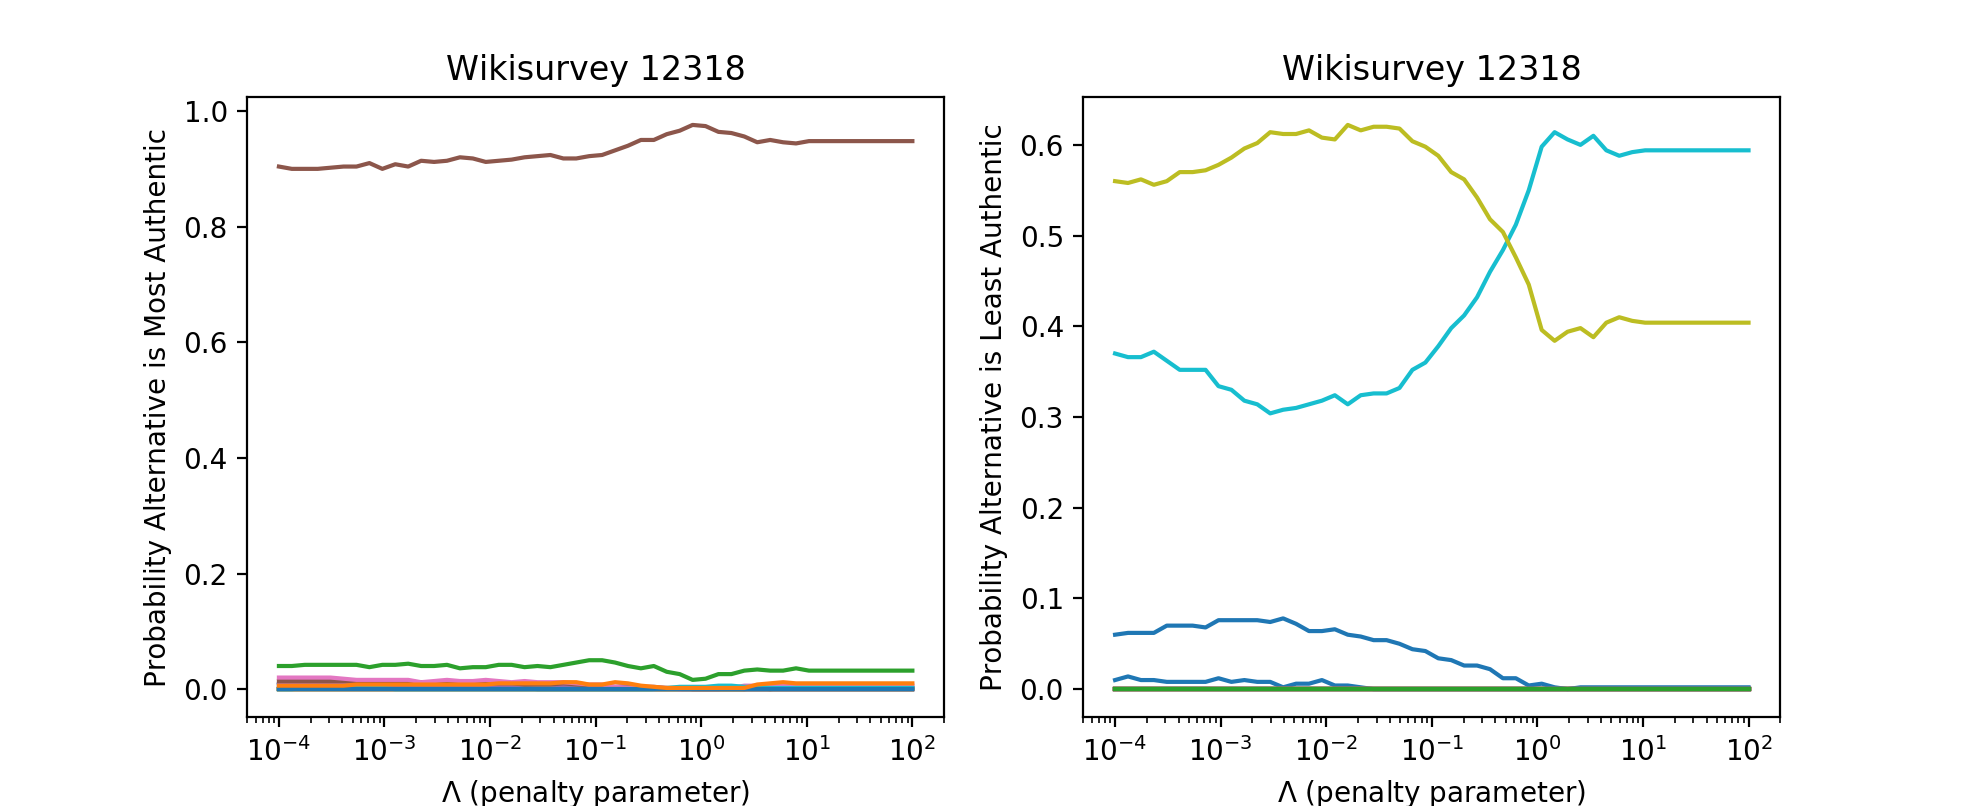

/Users/morrowwr/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


<IPython.core.display.Javascript object>


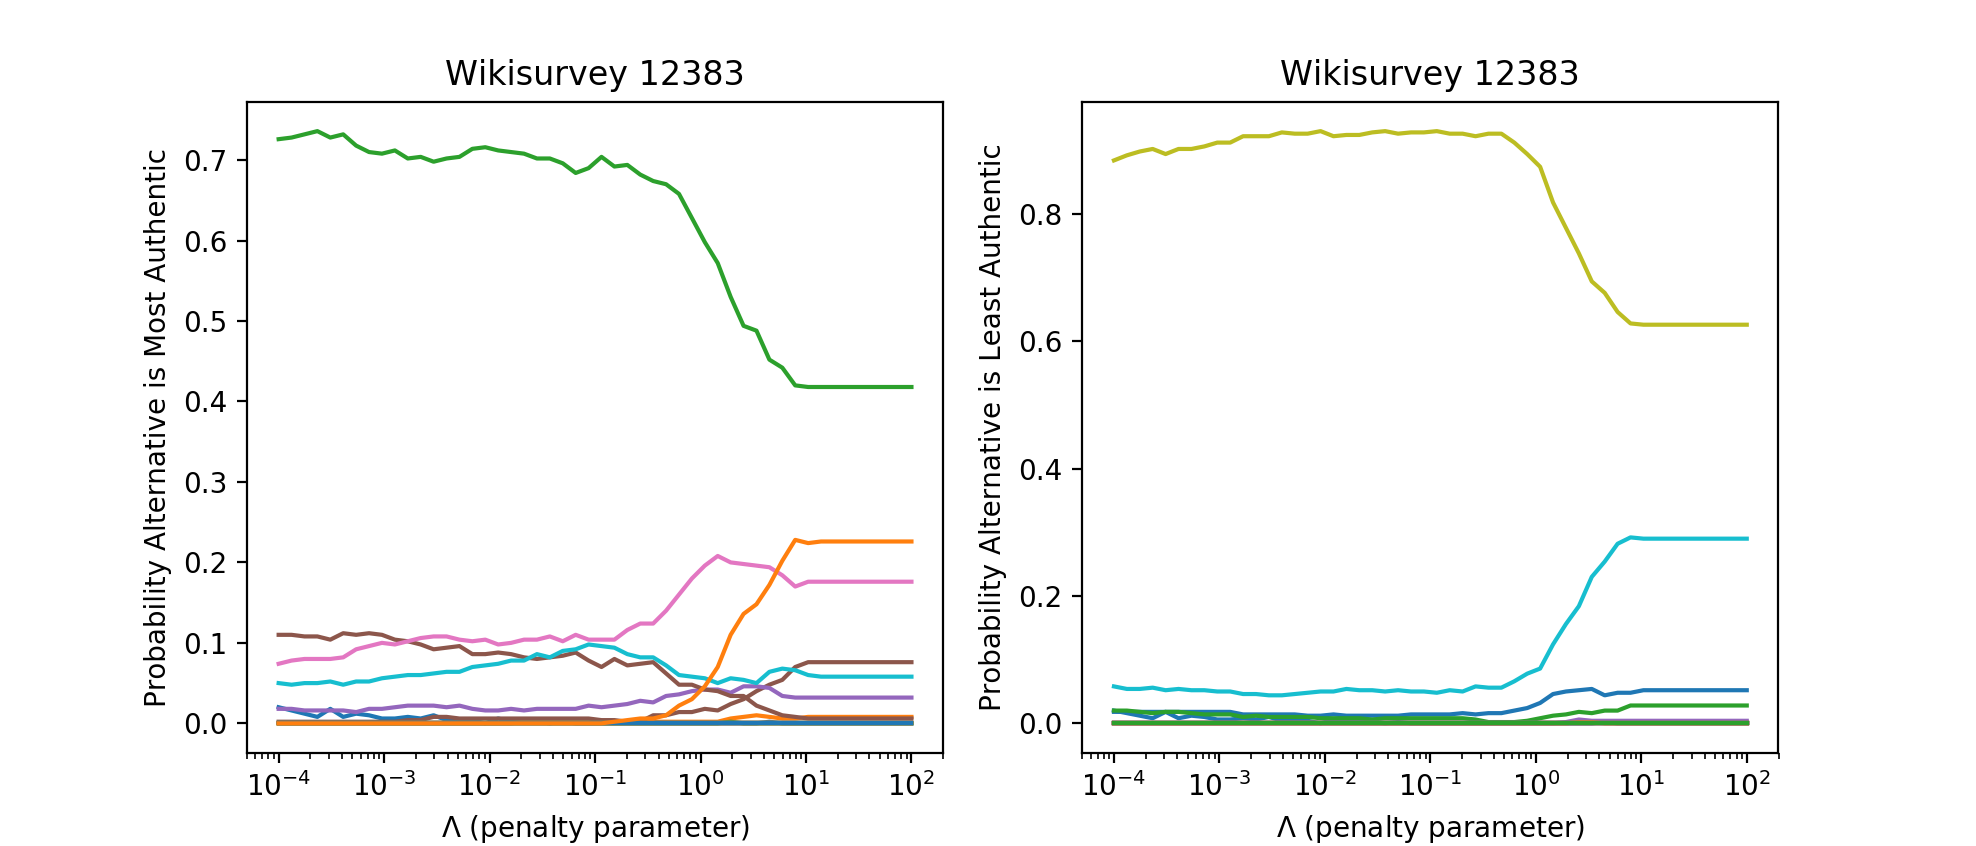

<IPython.core.display.Javascript object>


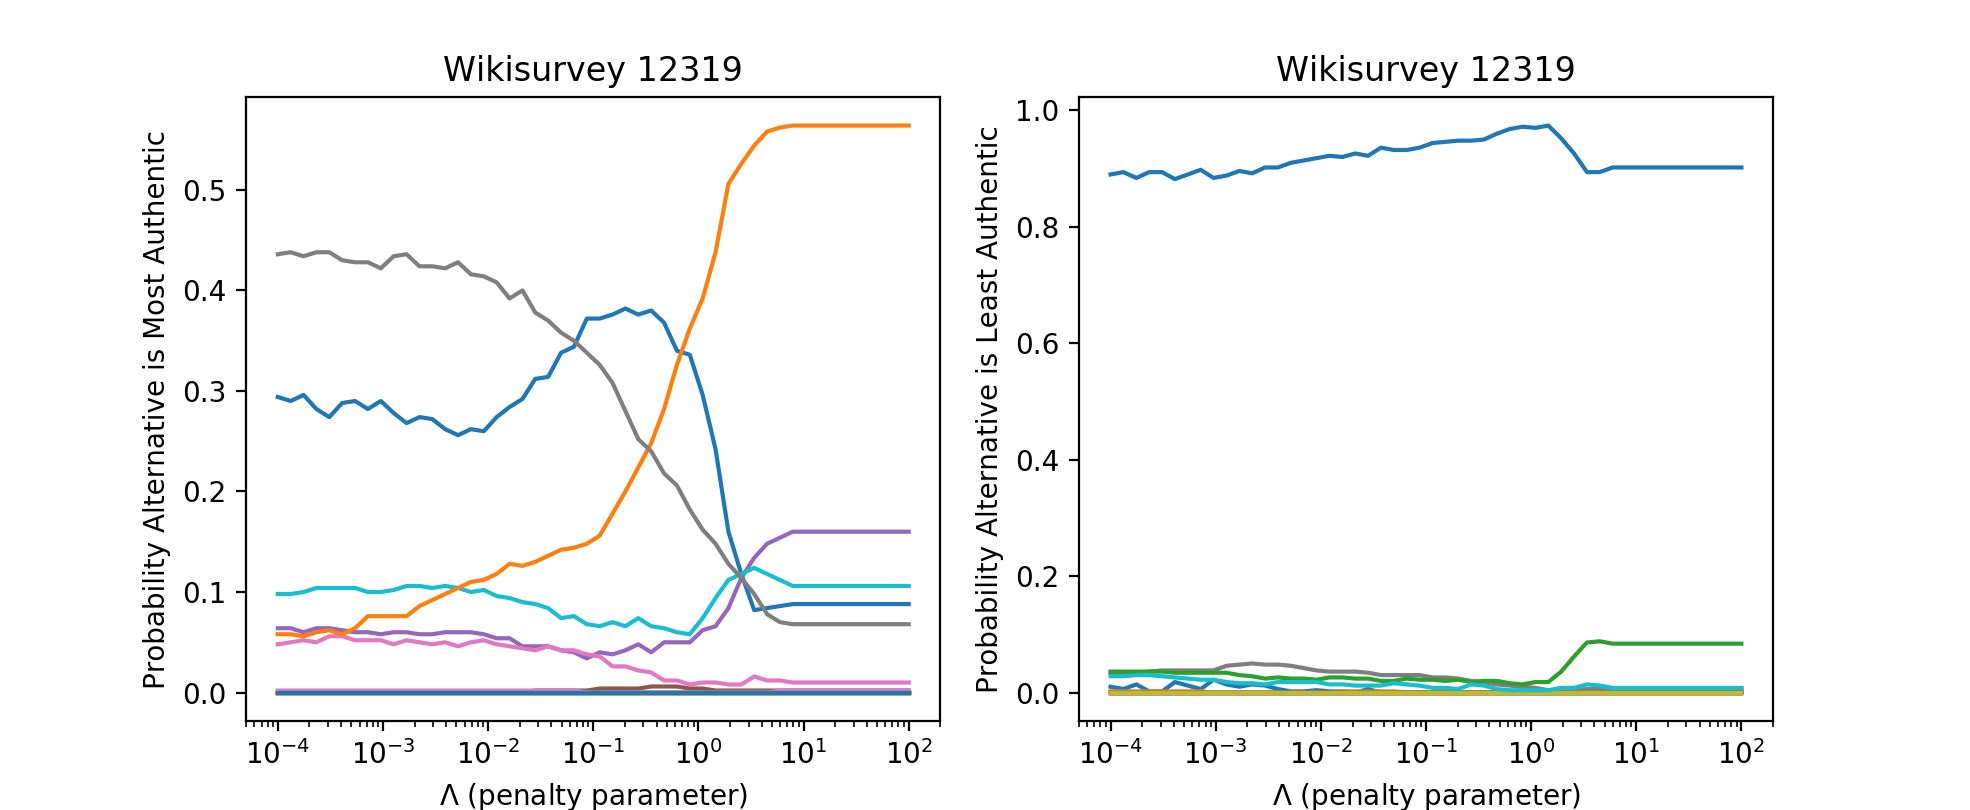

<IPython.core.display.Javascript object>


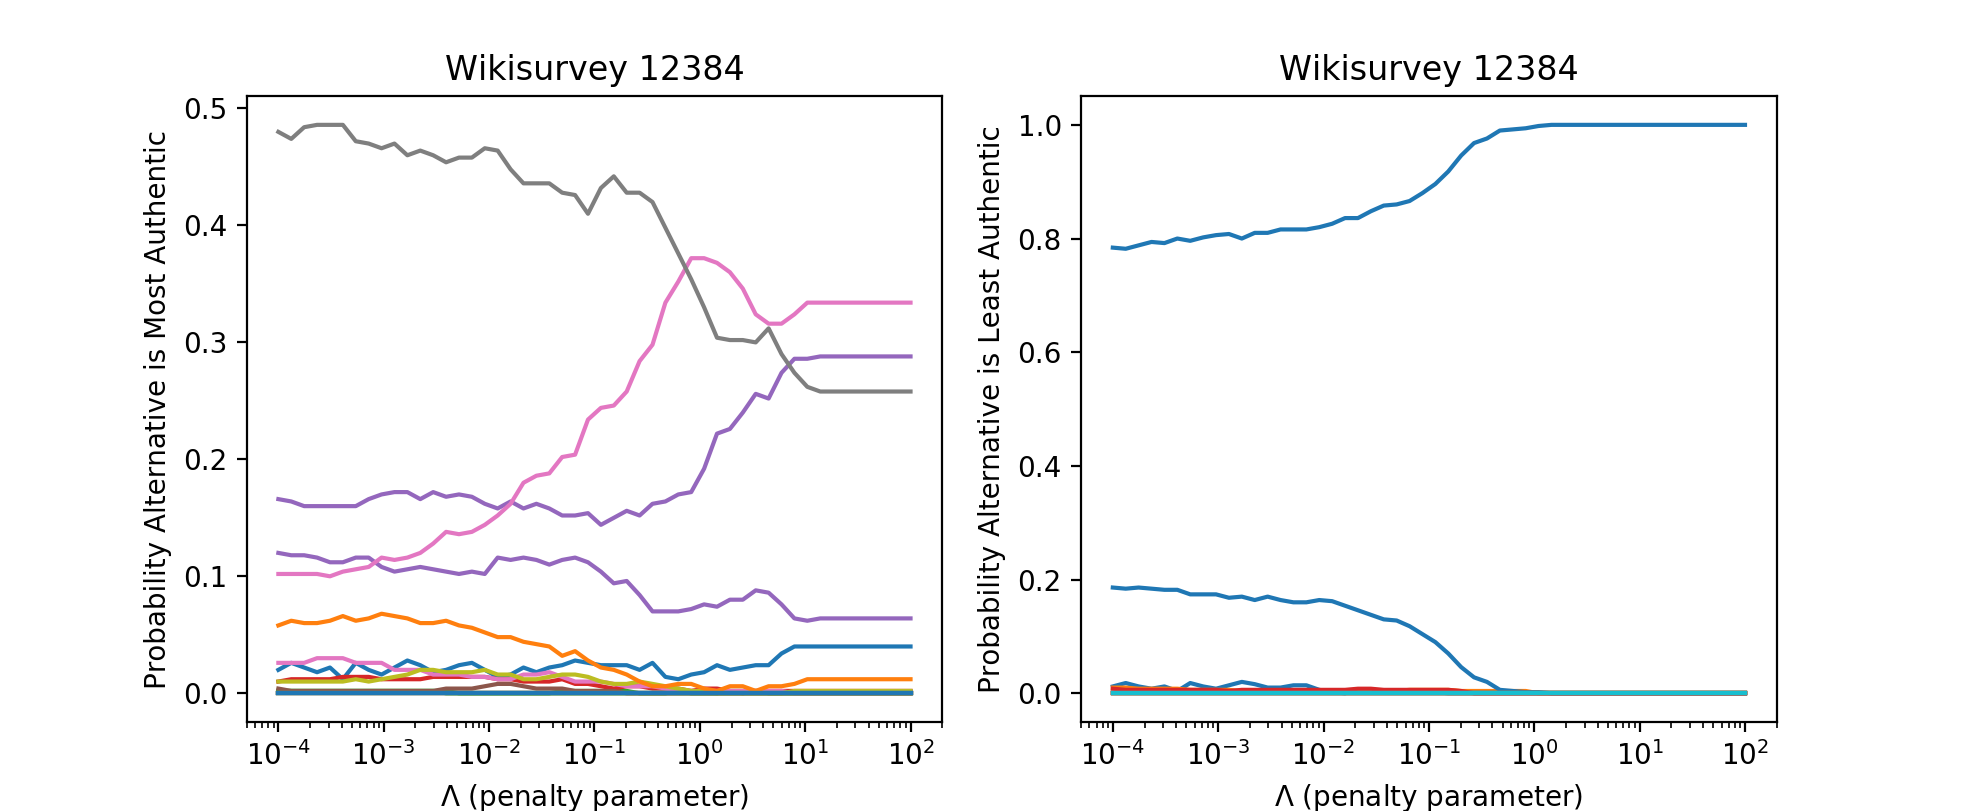

In [12]:

for set in sets :
    
    for l in set["labels"] : 
    
        A , count , branks , maxprb , minprb = None , 0 , None , None , None
        for s in range(0,S) : 
            try : 
                betas = np.fromfile( "%s/bootstrap/%s/betas-%i.bin" % (resdir,l,s) )
                if A is None : 
                    A = np.int( betas.shape[0] / T )
                    maxprb = np.zeros( (A,T) )
                    minprb = np.zeros( (A,T) )
                    # branks = np.zeros( (A,A,T) )
                betas = betas.reshape( (A,T) )
                mxalt = np.argmax( betas , axis=0 )
                mnalt = np.argmin( betas , axis=0 )
                for t in range(0,T) : 
                    maxprb[mxalt[t],t] += 1
                    minprb[mnalt[t],t] += 1
                #ranks = np.argsort( np.argsort( betas , axis=0 ) , axis=0 )
                #branks[:,ranks] += 1
                count += 1
            except FileNotFoundError as e : 
                pass

        maxprb = maxprb / count
        minprb = minprb / count

        pd.DataFrame( maxprb , columns=[ "Lambda=%0.6f" % l for l in lambdas ] ).to_csv( "beta-top-rank-%s.csv" % l )
        pd.DataFrame( minprb , columns=[ "Lambda=%0.6f" % l for l in lambdas ] ).to_csv( "beta-bottom-rank-%s.csv" % l )

        plt.figure()
        for a in range(0,A) : 
            plt.subplot(1,2,1), plt.semilogx( lambdas , maxprb[a,:] )
            plt.subplot(1,2,2), plt.semilogx( lambdas , minprb[a,:] )

        plt.subplot(1,2,1), 
        plt.title( 'Wikisurvey %s' % l )
        plt.xlabel( '$\Lambda$ (penalty parameter)' )
        plt.ylabel( 'Probability Alternative is Most Authentic' )

        plt.subplot(1,2,2), 
        plt.title( 'Wikisurvey %s' % l )
        plt.xlabel( '$\Lambda$ (penalty parameter)' )
        plt.ylabel( 'Probability Alternative is Least Authentic' )


# Deviations

The plots below show the _number_ of non-zero deviations estimated. Like with the likelihood above, we draw 90% envelopes with solid black lines, the mean with a dashed black line, and mean $\pm$ one standard deviation in dots. 

These results again support that between, roughly, $\Lambda = 0.3$ and $\Lambda = 2$ we are seeing the majority of beneficial effects from including deviations. 

<IPython.core.display.Javascript object>


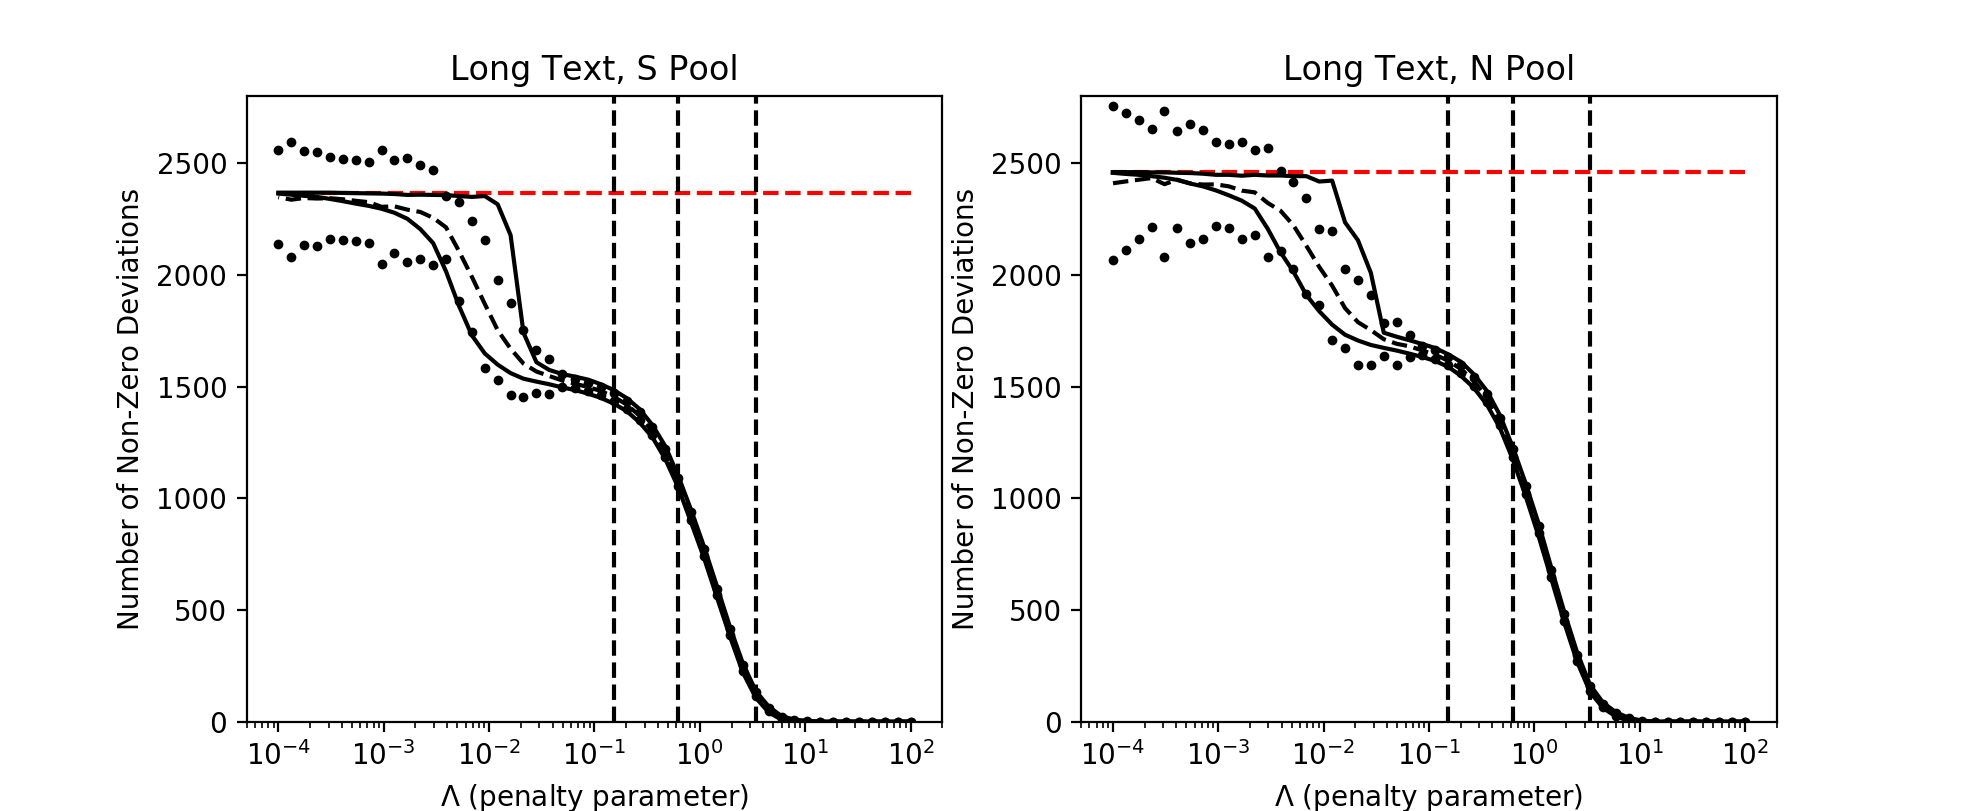

<IPython.core.display.Javascript object>


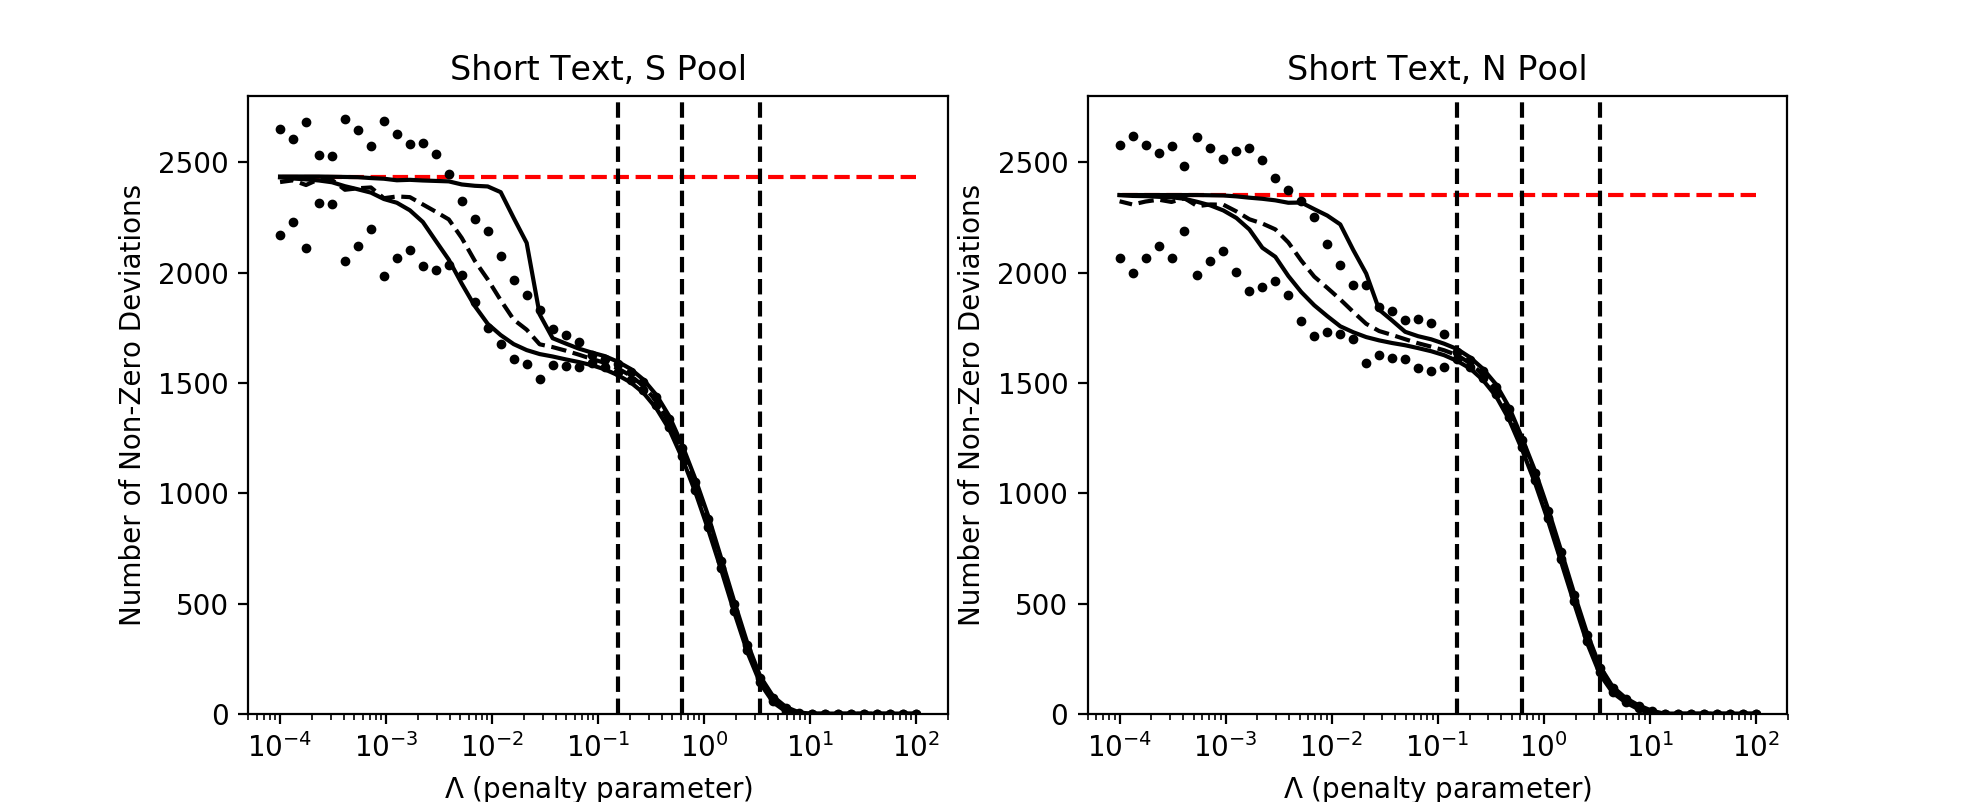

In [13]:
for set in sets : 
    
    f , axarr = plt.subplots( 1 , len(set["labels"]) )
    p = 0
    
    for l in set['labels'] : 
    
        A , I , count , nonzero = None , None , 0 , None
        for s in range(0,S) : 
            try : 
                delta = np.fromfile( "%s/bootstrap/%s/delta-%i.bin" % (resdir,l,s) )
                if I is None : 
                    A = np.int( np.fromfile( "%s/bootstrap/%s/betas-%i.bin" % (resdir,l,s) ).shape[0] / T )
                    I = np.int( delta.shape[0] / (A*T) )
                    nonzero = np.zeros( (S,T) )
                delta = delta.reshape( (I*A,T) )
                nonzero[s,:] = np.sum( np.abs( delta ) > 1.0e-6 , axis=0 )
                count += 1
            except FileNotFoundError as e : 
                pass

        m = nonzero.mean( axis=0 )
        s = nonzero.std( axis=0 )

        snonz = np.sort( nonzero , axis=0 )
        lower = np.int( np.floor( 0.05 * snonz.shape[0] ) )
        upper = np.int( np.ceil( 0.95 * snonz.shape[0] ) )

        axarr[p].semilogx( lambdas , I*A * np.ones( lambdas.shape ) , '--r' )
        axarr[p].semilogx( lambdas , snonz[upper,:] , '-k' )
        axarr[p].semilogx( lambdas , m + s , '.k' , Markersize=5 )
        axarr[p].semilogx( lambdas , m , '--k' )
        axarr[p].semilogx( lambdas , m - s , '.k' , Markersize=5 )
        axarr[p].semilogx( lambdas , snonz[lower,:] , '-k' )
        axarr[p].semilogx( lambdas[[lfix[0],lfix[0]]] , [0,2800] , '--k' )
        axarr[p].semilogx( lambdas[[lfix[1],lfix[1]]] , [0,2800] , '--k' )
        axarr[p].semilogx( lambdas[[lfix[2],lfix[2]]] , [0,2800] , '--k' )
        # axarr[p].set_title( 'Wikisurvey %s' % l )
        axarr[p].set_title( '%s' % (set['titles'][l]) )
        axarr[p].set_xlabel( '$\Lambda$ (penalty parameter)' )
        axarr[p].set_ylabel( 'Number of Non-Zero Deviations' )
        axarr[p].set_ylim( [0,2800] )
        
        p += 1

# Scoring

[Salagnik and Levy](http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0123483&type=printable) state that "The ideal summary of the opinion matrix will likely vary from setting to setting, but our preferred summary statistic is what we call the score of each [alternative], $\hat{S}_a$, the estimated chance that it will beat a randomly chosen [alternative] for a randomly chosen respondent." Note I change notation, in particular to reflect that this score is a random variable. 

For our setting, let us refine the notation a bit: Suppose we are focusing on alternative $a$ for scoring. Let $R_a \sim U[\{1,\dotsc,A\} \setminus \{a\}]$; that is, $\mathbb{P}(R_a = b) = 1/(A-1)$ for all $b \neq a$. Then let $C_i(a,b) \sim B(P_i(a,b))$ be individual $i$'s Bernoulli "choice" variable between alternatives $a$ and $b$. 

For the Logit model described above, the "randomly chosen respondent" is irrelvant: the Score is 
$$
    S_a^L = \mathbb{P}( C(a,R_a) = a )
          = \frac{1}{A-1} \sum_{b \neq a} \mathbb{P}( C(a,b) = a )
          = \frac{1}{A-1} \sum_{b \neq a} \frac{ e^{\beta_a} }{ e^{\beta_a} + e^{\beta_b} }
$$
For the `idLogit` model, this must be conditioned over a "randomly chosen respondent": 
$$
    S_a = \mathbb{P}( C(a,R_a) = a )
        = \frac{1}{I} \sum_{i=1}^I \mathbb{P}( C_i(a,R_a) = a )
        = \frac{1}{I(A-1)} \sum_{i=1}^I \sum_{b \neq a} \frac{ e^{\beta_a+\delta_{i,a}} }{ e^{\beta_a+\delta_{i,a}} + e^{\beta_b+\delta_{i,b}} }
$$
These scores lie in $[0,1]$; they can be scaled to percentages in $[0,100]$ if we like by multiplying by $100$. 

**These score calculations take a little while.** So this is a good place to break up the calculation and plotting blocks. 

### Calculations

Takes time, do with caution. (But not _that_ much time.) 

In [24]:
for set in sets : 
    
    for L in set['labels'] : 
    
        A , I , count , theta , score , probs , theta_fixed = None , None , 0 , None , None , None , {}
        
        try : 

            betas = np.fromfile( "%s/actual/%s/betas.bin" % (resdir,L) )
            delta = np.fromfile( "%s/actual/%s/delta.bin" % (resdir,L) )

            if A is None :
                A = np.int( betas.shape[0] / T )
                I = np.int( delta.shape[0] / (A*T) )
                theta = np.zeros( (A,T,I) ) 
                probs = np.zeros( (A-1,T,I) )
                score = np.zeros( (A,T) )
                for l in [27,31,35] : 
                    theta_fixed[l] = np.zeros( (A,I) )

            betas = betas.reshape( ( A ,T) )
            delta = delta.reshape( (I*A,T) )
            for i in range(0,I) : 
                theta[:,:,i] = betas + delta[i*A:(i+1)*A,:]

            for a in range(0,A) : 
                for b in range(0,a) : 
                    probs[ b ,:,:] = np.exp( theta[b,:,:] - theta[a,:,:] )
                for b in range(a+1,A) : 
                    probs[b-1,:,:] = np.exp( theta[b,:,:] - theta[a,:,:] )
                probs = 1.0 / ( 1.0 + probs )
                score[a,:] = np.mean( np.mean( probs , axis=2 ) , axis=0 )

            count += 1

            for l in [27,31,35] : 
                theta_fixed[l][:,:] = theta[:,l,:] # A x I

        except FileNotFoundError as e : 
            pass
        
        
        
        score.tofile( "%s/actual/%s/scores.bin" % (resdir,L) )
        for l in [27,31,35] : 
            theta_fixed[l].tofile( "%s/actual/%s/thetas_%i.bin" % (resdir,L,l) )
        

In [14]:
for set in sets : 
    
    for L in set['labels'] : 
    
        A , I , count , theta , score , probs , theta_fixed = None , None , 0 , None , None , None , {}
        for s in range(0,S) : 
            try : 

                betas = np.fromfile( "%s/bootstrap/%s/betas-%i.bin" % (resdir,L,s) )
                delta = np.fromfile( "%s/bootstrap/%s/delta-%i.bin" % (resdir,L,s) )

                if A is None :
                    A = np.int( betas.shape[0] / T )
                    I = np.int( delta.shape[0] / (A*T) )
                    theta = np.zeros( (A,T,I) ) 
                    probs = np.zeros( (A-1,T,I) )
                    score = np.zeros( (S,A,T) )
                    for l in [27,31,35] : 
                        theta_fixed[l] = np.zeros( (S,A,I) )

                betas = betas.reshape( ( A ,T) )
                delta = delta.reshape( (I*A,T) )
                for i in range(0,I) : 
                    theta[:,:,i] = betas + delta[i*A:(i+1)*A,:]
                
                for a in range(0,A) : 
                    for b in range(0,a) : 
                        probs[ b ,:,:] = np.exp( theta[b,:,:] - theta[a,:,:] )
                    for b in range(a+1,A) : 
                        probs[b-1,:,:] = np.exp( theta[b,:,:] - theta[a,:,:] )
                    probs = 1.0 / ( 1.0 + probs )
                    
                    score[s,a,:] = np.mean( np.mean( probs , axis=2 ) , axis=0 )
                    
                count += 1
                
                for l in [27,31,35] : 
                    theta_fixed[l][s,:,:] = theta[:,l,:] # A x I
                
            except FileNotFoundError as e : 
                pass
        
        score.tofile( "%s/bootstrap/%s/scores.bin" % (resdir,L) )
        for l in [27,31,35] : 
            theta_fixed[l].tofile( "%s/bootstrap/%s/thetas_%i.bin" % (resdir,L,l) )
        

KeyboardInterrupt: 

### Plots

Here we start drafting plots of the authenticity scores with confidence intervals derived from bootstrapping. 

/Users/morrowwr/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/morrowwr/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<IPython.core.display.Javascript object>


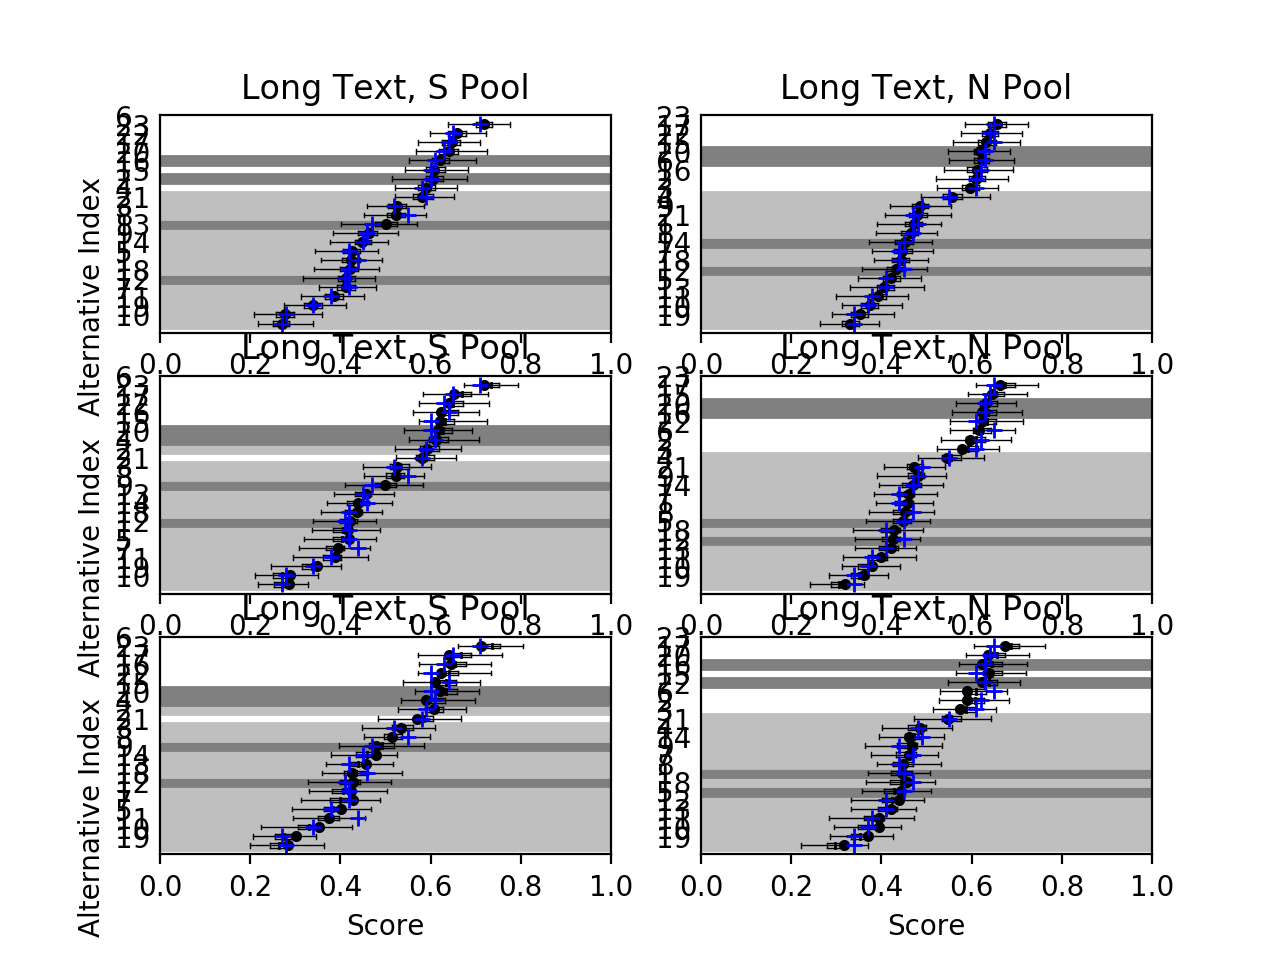

<IPython.core.display.Javascript object>


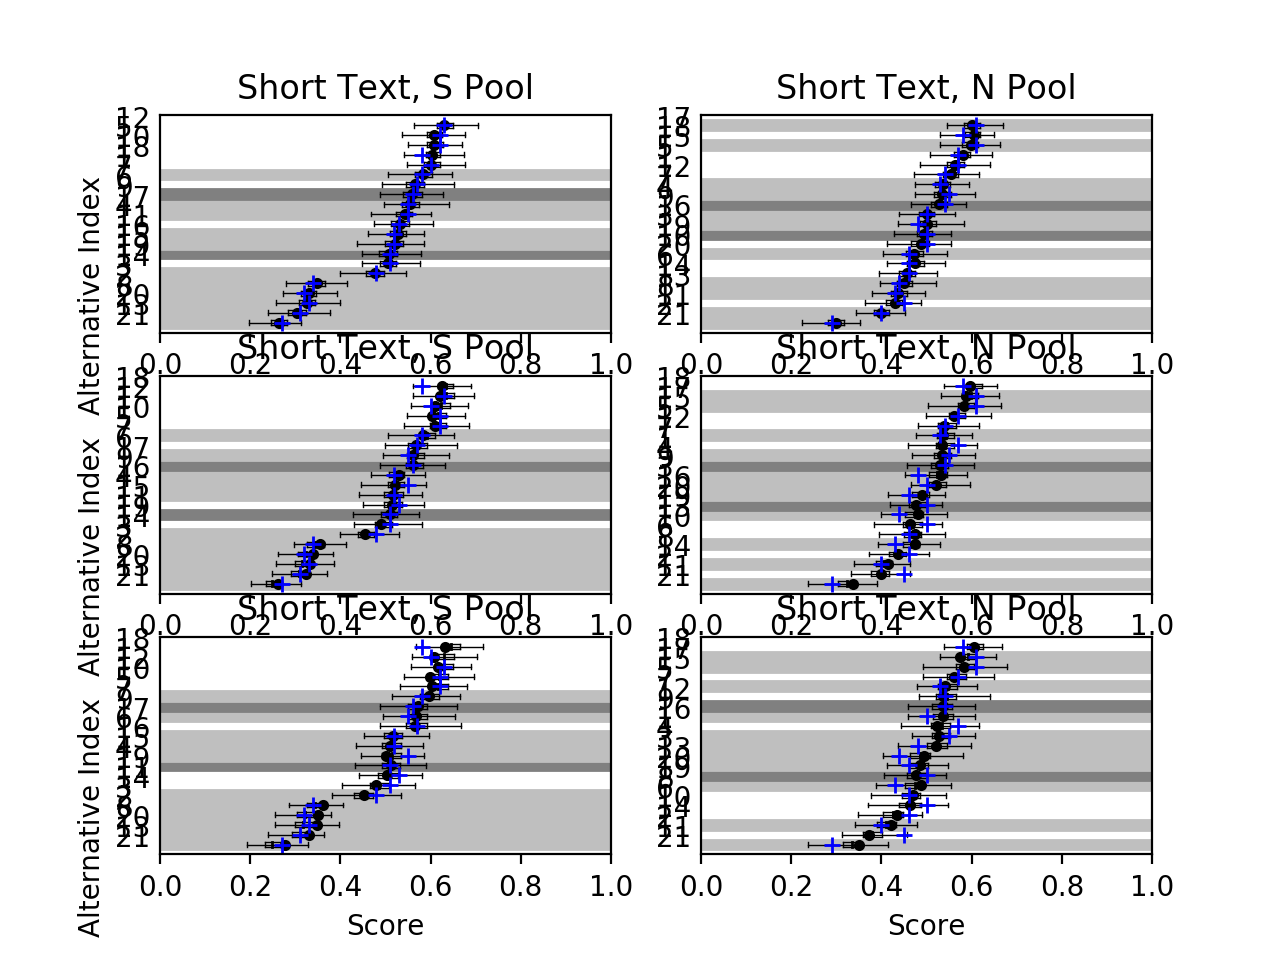

In [15]:
sns.reset_orig()

for set in sets : 
    
    f, axarr = plt.subplots( len(lfix) , len(set['labels']) )
    if( len(lfix) == 1 ) : 
        axarr = [ axarr ]
    
    r , c = 0 , 0
    
    for L in set['labels'] : 
    
        A , score = None , None
        if A is None : 
            betas = np.fromfile( "%s/bootstrap/%s/betas-%i.bin" % (resdir,L,0) )
            A = np.int( betas.shape[0] / T )

        act_score = np.fromfile( "%s/actual/%s/scores.bin" % (resdir,L) ).reshape( (A,T) )
        score = np.fromfile( "%s/bootstrap/%s/scores.bin" % (resdir,L) ).reshape( (S,A,T) )
        means , stddv = np.mean( score , axis=0 ) , np.std( score , axis=0 )

        """
        # simple count-based rankings
        
        df = pd.read_csv( "%s/wikisurvey_%s_ready_withskip.csv" % (datadir,L) )
        
        rdf = pd.DataFrame( np.zeros( ( A , 4 ) ) , 
                               index=np.arange(0,A,1) + 1 , 
                               columns=[ 'Left Appearances' , 'Right Appearances' , 
                                            'Appearances' , 'Emp Win Freq' ] )
        rdf['Left Appearances']  = df.groupby( 'Left Choice ID' )['Winner'].count().values
        rdf['Right Appearances'] = df.groupby( 'Right Choice ID' )['Winner'].count().values
        rdf['Appearances'] = rdf['Left Appearances'] + rdf['Right Appearances']
        
        df = pd.read_csv( "%s/wikisurvey_%s_ready_noskip.csv" % (datadir,L) )
        
        df['Winner ID'] = df['Left Choice ID'] * ( df['Winner'] + 1 ) / 2 \
                              + df['Right Choice ID'] * ( 1 - df['Winner'] ) / 2 + 1
        
        rdf['Winner'] = df.groupby( 'Winner ID' )['Winner'].count()
        rdf['Emp Win Freq'] = rdf['Winner'] / rdf['Appearances']
        
        ewf = rdf['Emp Win Freq']
        """
        
        for l in lfix : 

            mean = np.mean( score[:,:,l] , axis=0 )
            meds = np.median( score[:,:,l] , axis=0 )
            ssrt = np.sort( score[:,:,l] , axis=0 )
            lowr = ssrt[ np.int( np.floor( 0.20*ssrt.shape[0] ) ) , : ]
            uppr = ssrt[ np.int( np.ceil( 0.80*ssrt.shape[0] ) ) , : ]
            minr = ssrt[0,:] 
            maxr = ssrt[-1,:] 
    
            inds = np.argsort( meds )
            mean , meds , lowr , uppr , minr , maxr \
                = mean[inds] , meds[inds] , lowr[inds] , uppr[inds] , minr[inds] , maxr[inds]
            
            for a in range(0,A) : 
                axarr[r][c].plot( [minr[a],maxr[a]] , [a,a] , '-k' , Linewidth=0.5 )
                for x in [minr[a],lowr[a],uppr[a],maxr[a]] : 
                    axarr[r][c].plot( [x,x] , [a-0.25,a+0.25] , '-k' , Linewidth=0.5 )
                axarr[r][c].plot( [meds[a],meds[a]] , [a-0.25,a+0.25] , '-k' , Linewidth=1.0 )
                axarr[r][c].plot( [lowr[a],uppr[a]] , [a-0.25,a-0.25] , '-k' , Linewidth=0.5 )
                axarr[r][c].plot( [lowr[a],uppr[a]] , [a+0.25,a+0.25] , '-k' , Linewidth=0.5 )
                if set['alt_code'][inds[a]] == 'E' : 
                    clr = 0.75
                    axarr[r][c].fill( [0,1,1,0] , [a-0.5,a-0.5,a+0.5,a+0.5] , Color=[clr,clr,clr] )
                elif set['alt_code'][inds[a]] == 'I' : 
                    pass
                else : 
                    clr = 0.50
                    axarr[r][c].fill( [0,1,1,0] , [a-0.5,a-0.5,a+0.5,a+0.5] , Color=[clr,clr,clr] )
                    pass
                # this is really an axis tick label... 
                axarr[r][c].text( -0.1 , a-0.25 , "%i" % ( inds[a]+1 ) )
                
            # add AOI Score to plot
            axarr[r][c].plot( act_score[inds,l] , np.arange(0,A) , '.k' )
            axarr[r][c].plot( set['aoiscore'][L][inds]/100.0 , np.arange(0,A) , '+b' )
            
            # add simple count based rankings to plot
            # axarr[r][c].plot( ewf.values[inds] , np.arange(0,A) , '.r' )
            
            # axarr[r][c].set_title( "%s , $\Lambda$ = %0.2f" % (set['titles'][L],lambdas[l]) )
            axarr[r][c].set_title( "%s" % set['titles'][L] )
            axarr[r][c].axis( [0,1,-1,A] )
            #axarr[r][c].yaxis.set_visible(False)
            axarr[r][c].yaxis.set_major_locator(plt.NullLocator())
            if r == len(lfix)-1 : 
                # axarr[r][c].xaxis.set_visible(False)
                axarr[r][c].set_xlabel( "Score" )
            # axarr[r][c].xlabel( "Score" )
            
            if( c == 0 ) : 
                axarr[r][c].text( -0.15 , 0.6*A , "Alternative Index" , rotation=90 , horizontalalignment='center' )
            
            r += 1
            
        c += 1
        r = 0
        

### Nice Plotting

The following cell is to facilitate "nice" plotting for publication. 

<IPython.core.display.Javascript object>


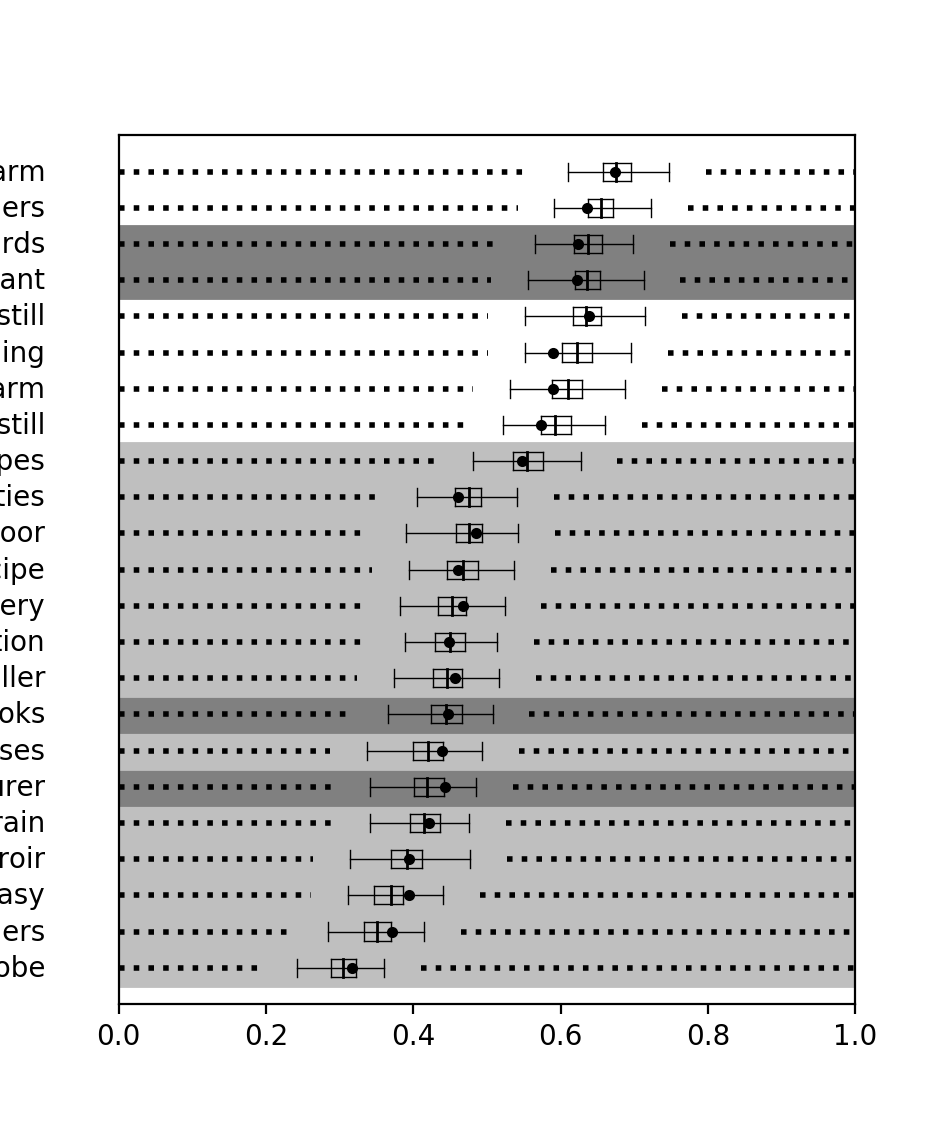

['We use our own grain, allowing us to make malt originating from our own farm'
 'We distill all our spirits in-house and source grain only from local farmers'
 'We carefully tend our farm to ensure the grain we use meets our standards'
 'We malt the grain ourselves, ensuring we get the aroma and taste we want'
 'We distill all of our spirits by artisanal methods using our own handmade still'
 'We own every aspect of the spirits production process, from growing to bottling'
 'Our distillery is true grain-to-glass, sourcing only from our own farm'
 'All of our spirits are distilled in-house using our own handmade copper still'
 'All of our spirits are made using ingredients following secret family recipes'
 'Our barrels are hand-crafted from aged oak trees grown on select properties'
 'We only use malt processed by hand-raking grain on our special malting floor'
 'Our spirits are blended following our master distillers intuition, rather than a recipe'
 'The ingredients we use come only 

In [16]:

plt.figure( )
    
set = sets[0]
L = set['labels'][1]
lfix_orig = lfix
lfix = 18

A , score = None , None
if A is None : 
    betas = np.fromfile( "%s/bootstrap/%s/betas-%i.bin" % (resdir,L,0) )
    A = np.int( betas.shape[0] / T )

act_score = np.fromfile( "%s/actual/%s/scores.bin" % (resdir,L) ).reshape( (A,T) )
score = np.fromfile( "%s/bootstrap/%s/scores.bin" % (resdir,L) ).reshape( (S,A,T) )
means , stddv = np.mean( score , axis=0 ) , np.std( score , axis=0 )

mean = np.mean( score[:,:,lfix] , axis=0 )
meds = np.median( score[:,:,lfix] , axis=0 )
ssrt = np.sort( score[:,:,lfix] , axis=0 )
lowr = ssrt[ np.int( np.floor( 0.20*ssrt.shape[0] ) ) , : ]
uppr = ssrt[ np.int( np.ceil( 0.80*ssrt.shape[0] ) ) , : ]
minr = ssrt[0,:] 
maxr = ssrt[-1,:] 

inds = np.argsort( meds )
mean , meds , lowr , uppr , minr , maxr \
    = mean[inds] , meds[inds] , lowr[inds] , uppr[inds] , minr[inds] , maxr[inds]

for a in range(0,A) : 
    
    plt.plot( [minr[a],maxr[a]] , [a,a] , '-k' , Linewidth=0.5 )
    for x in [minr[a],lowr[a],uppr[a],maxr[a]] : 
        plt.plot( [x,x] , [a-0.25,a+0.25] , '-k' , Linewidth=0.5 )
        
    plt.plot( [0,minr[a]-0.05] , [a,a] , ':k' , linewidth=2 )
    plt.plot( [maxr[a]+0.05,1] , [a,a] , ':k' , linewidth=2 )
        
    plt.plot( [meds[a],meds[a]] , [a-0.25,a+0.25] , '-k' , Linewidth=1.0 )
    plt.plot( [lowr[a],uppr[a]] , [a-0.25,a-0.25] , '-k' , Linewidth=0.5 )
    plt.plot( [lowr[a],uppr[a]] , [a+0.25,a+0.25] , '-k' , Linewidth=0.5 )
    
    # fill in according to alternative "coding"
    if set['alt_code'][inds[a]] == 'E' : 
        clr = 0.75
        plt.fill( [0,1,1,0] , [a-0.5,a-0.5,a+0.5,a+0.5] , Color=[clr,clr,clr] )
    elif set['alt_code'][inds[a]] == 'I' : 
        pass
    else : 
        clr = 0.50
        plt.fill( [0,1,1,0] , [a-0.5,a-0.5,a+0.5,a+0.5] , Color=[clr,clr,clr] )
        
    # this is really an axis tick label... 
    # plt.text( -0.1 , a-0.25 , "%i" % ( inds[a]+1 ) , horizontalalignment='right' )
    plt.text( -0.1 , a-0.25 , "%s" % ( set['alt_text'][inds[a]] ) , horizontalalignment='right' )

# add AOI Score to plot
plt.plot( act_score[inds,l] , np.arange(0,A) , '.k' )
# plt.plot( set['aoiscore'][L][inds]/100.0 , np.arange(0,A) , '+b' )

# plt.title( "%s" % set['titles'][L] )
plt.axis( [0,1,-1,A] )
plt.yticks( [] )
# plt.xlabel( "Probability an alternative wins a random pairing, for a random respondent" )
        
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
print( set['alt_text'][inds][::-1] )

lfix = lfix_orig

### Is Our Analysis Better than "Voting"? 

Often the simplest thing to do is best. Or, at the very least, has alot of merit. In this case, the simplest thing is probably the Empirical Win Fractions (EWFs): the fraction of times an alternative wins over the number of times it appeared in a comparison. The plots below show that our (complicated) calculations -- the `idLogit` model followed by the scores -- are not particularly distinct from the EWFs. (Nor are the Bayesian estimates returned by the platform used to collect data.) 

<IPython.core.display.Javascript object>


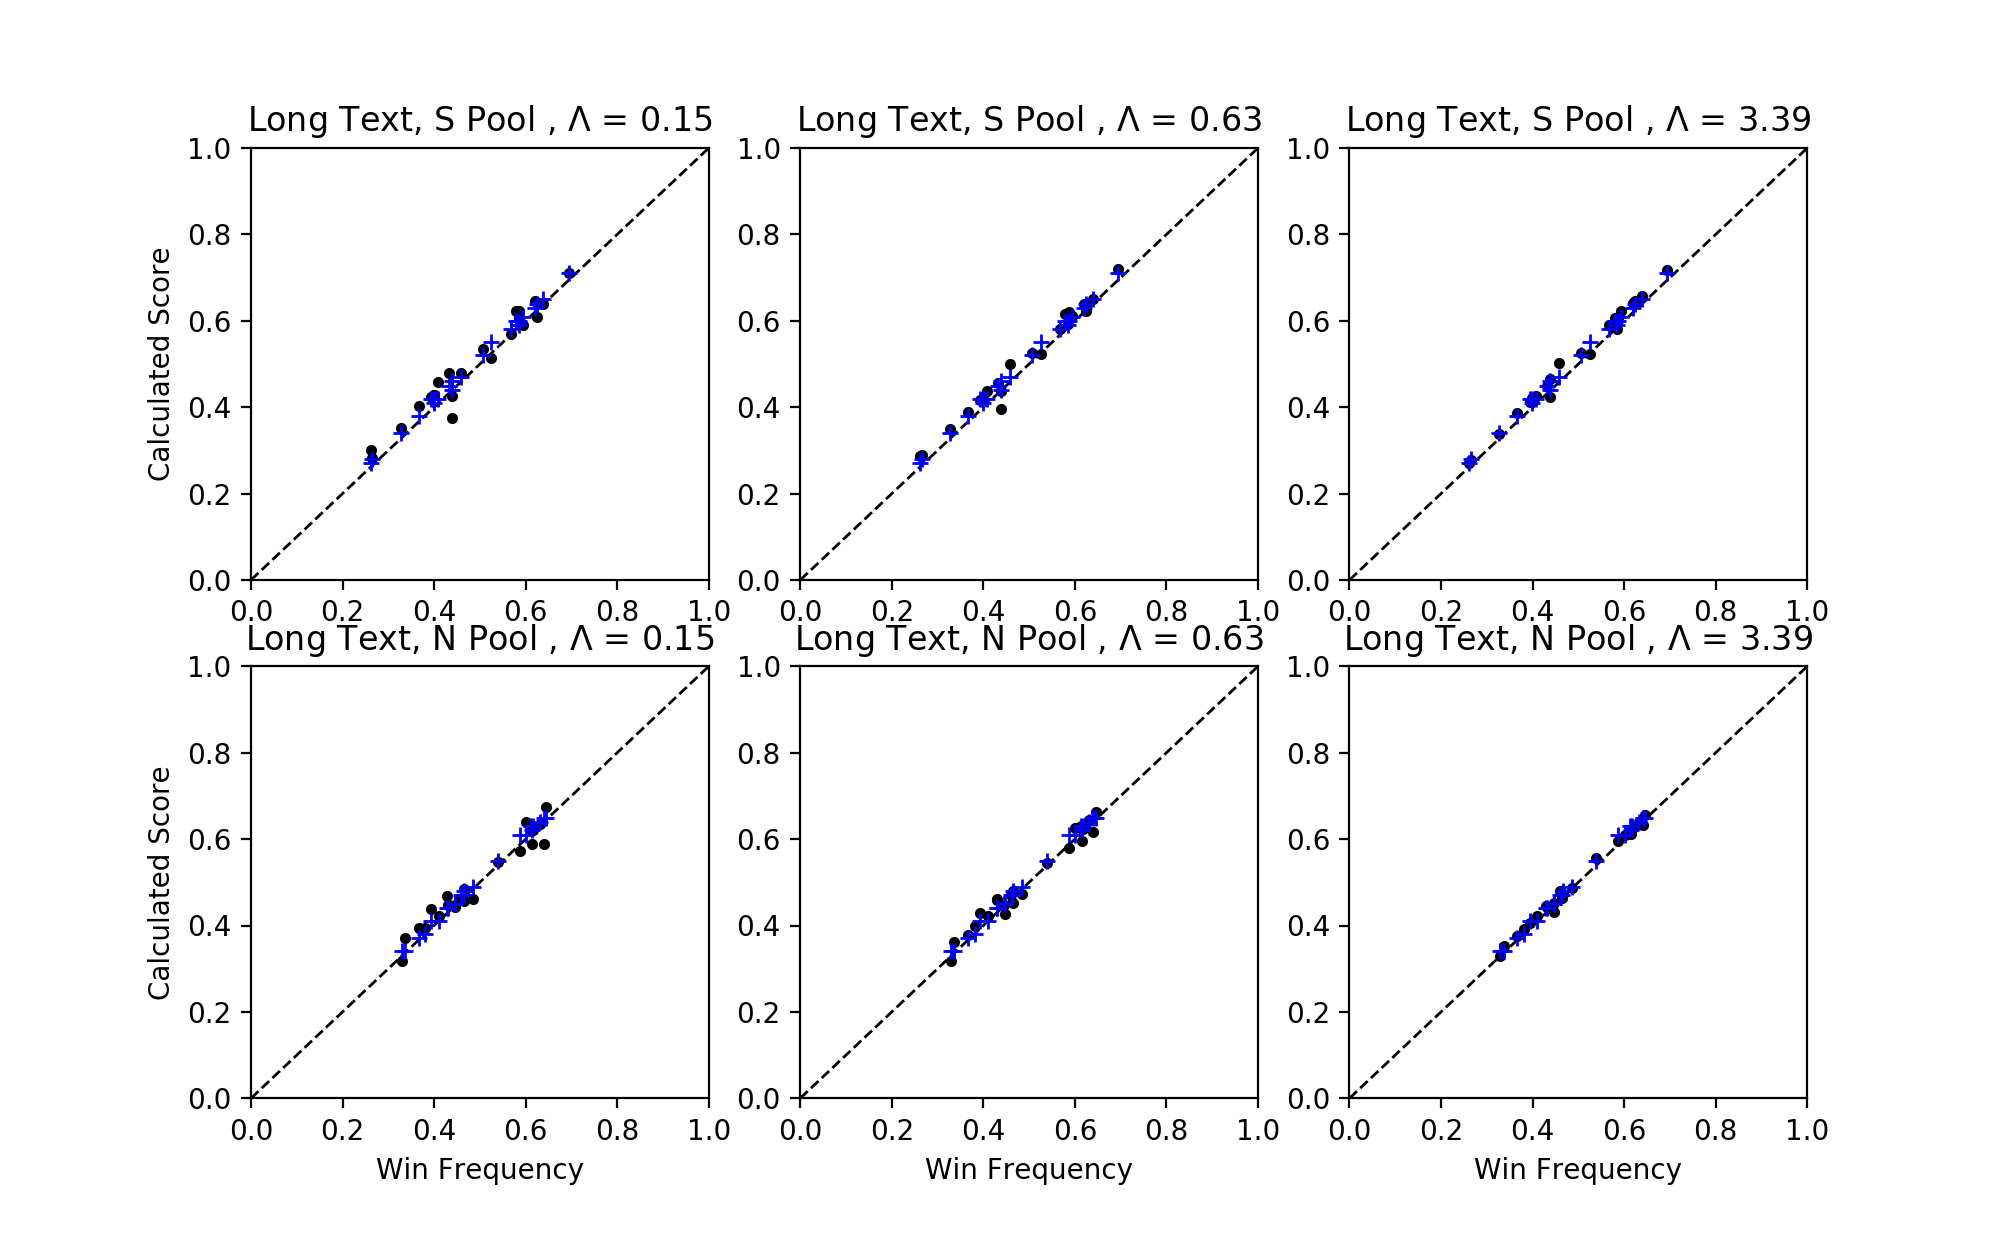

<IPython.core.display.Javascript object>


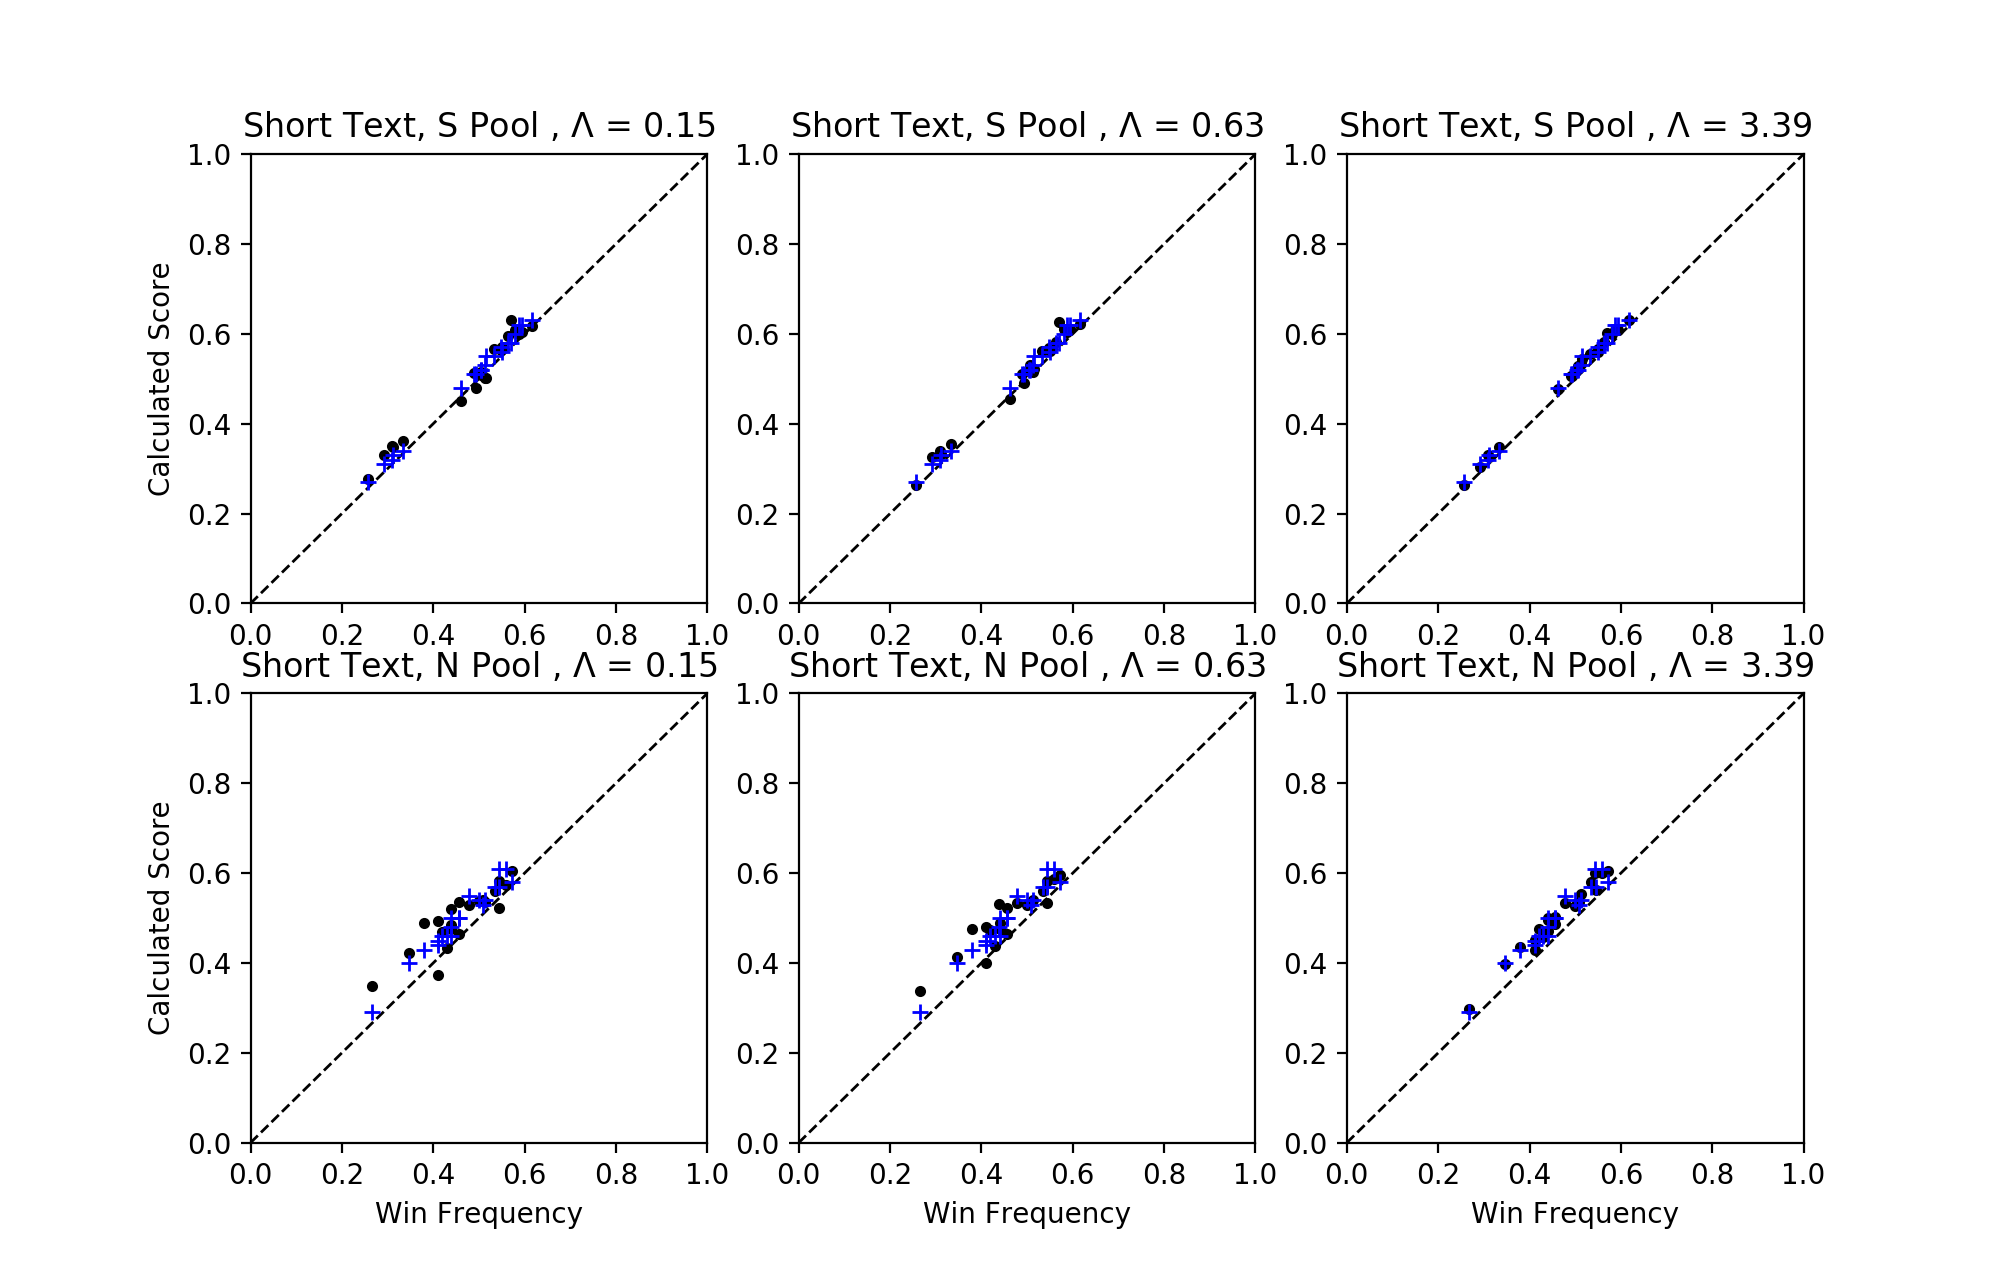

In [17]:
for set in sets : 
    
    f, axarr = plt.subplots(len(set['labels']),len(lfix))
    r , c = 0 , len(lfix) - 1
    
    for L in set['labels'] : 
    
        A , score = None , None
        if A is None : 
            betas = np.fromfile( "%s/bootstrap/%s/betas-%i.bin" % (resdir,L,0) )
            A = np.int( betas.shape[0] / T )
            
        act_score = np.fromfile( "%s/actual/%s/scores.bin" % (resdir,L) ).reshape( (A,T) )
        
        # simple count-based rankings
        
        df = pd.read_csv( "%s/wikisurvey_%s_ready_withskip.csv" % (datadir,L) )
        
        rdf = pd.DataFrame( np.zeros( ( A , 4 ) ) , 
                               index=np.arange(0,A,1) + 1 , 
                               columns=[ 'Left Appearances' , 'Right Appearances' , 
                                            'Appearances' , 'Emp Win Freq' ] )
        rdf['Left Appearances']  = df.groupby( 'Left Choice ID' )['Winner'].count().values
        rdf['Right Appearances'] = df.groupby( 'Right Choice ID' )['Winner'].count().values
        rdf['Appearances'] = rdf['Left Appearances'] + rdf['Right Appearances']
        
        df = pd.read_csv( "%s/wikisurvey_%s_ready_noskip.csv" % (datadir,L) )
        
        df['Winner ID'] = df['Left Choice ID'] * ( df['Winner'] + 1 ) / 2 \
                              + df['Right Choice ID'] * ( 1 - df['Winner'] ) / 2 + 1
        
        rdf['Winner'] = df.groupby( 'Winner ID' )['Winner'].count()
        rdf['Emp Win Freq'] = rdf['Winner'] / rdf['Appearances']
        
        ewf = rdf['Emp Win Freq']
        
        for l in lfix : 
            
            axarr[r][c].plot( [0,1] , [0,1] , '--k' , Linewidth="1" )
            axarr[r][c].plot( ewf.values , act_score[:,l] , '.k' )
            axarr[r][c].plot( ewf.values , set['aoiscore'][L][:A]/100.0 , '+b' )
            
            axarr[r][c].set_title( "%s , $\Lambda$ = %0.2f" % (set['titles'][L],lambdas[l]) )
            axarr[r][c].axis( [0,1,0,1] )
            if c == 0 : 
                axarr[r][c].set_ylabel( "Calculated Score" )
            if r == len(set['labels']) - 1 : 
                axarr[r][c].set_xlabel( "Win Frequency" )

            c -= 1
        
        c = len(lfix) - 1
        r += 1

# Scoring I/E/I+E

We can use these more detailed estimates to compute scores for I/E/I+E alternatives as well. 

In [18]:
for set in sets : 

    C = {   'I' : np.where( np.array(set['alt_code']) == 'I' )[0].tolist() , 
            'E' : np.where( np.array(set['alt_code']) == 'E' )[0].tolist() , 
          'I+E' : np.where( np.array(set['alt_code']) == 'E+I' )[0].tolist() }
    
    print( C )
    
    D = {}
    for c in C : 
        D[c] = []
        for d in C : 
            if d is not c : 
                D[c] += C[d]

    print( D )


{'I': [1, 5, 15, 16, 21, 22], 'E': [0, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 18, 20], 'I+E': [7, 14, 17, 19]}
{'I': [0, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 18, 20, 7, 14, 17, 19], 'E': [1, 5, 15, 16, 21, 22, 7, 14, 17, 19], 'I+E': [1, 5, 15, 16, 21, 22, 0, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 18, 20]}
{'I': [0, 4, 5, 9, 10, 11, 13, 17], 'E': [1, 2, 3, 6, 7, 12, 14, 15, 16, 19, 20], 'I+E': [8, 18]}
{'I': [1, 2, 3, 6, 7, 12, 14, 15, 16, 19, 20, 8, 18], 'E': [0, 4, 5, 9, 10, 11, 13, 17, 8, 18], 'I+E': [0, 4, 5, 9, 10, 11, 13, 17, 1, 2, 3, 6, 7, 12, 14, 15, 16, 19, 20]}


In [19]:

for set in sets : 
    
    C = {   'I' : np.where( np.array(set['alt_code']) == 'I' )[0].tolist() , 
            'E' : np.where( np.array(set['alt_code']) == 'E' )[0].tolist() , 
          'I+E' : np.where( np.array(set['alt_code']) == 'E+I' )[0].tolist() }
    
    notC = {}
    for c in C : 
        notC[c] = []
        for d in C : 
            if d is not c : 
                notC[c] += C[d]
        
    k = {}
    for c in C : 
        k[c] = 1.0 / float(len(C[c]))
    
    for L in set['labels'] : 
        
        print( "working on %s" % L )
    
        A , I , count , theta , score , probs = None , None , 0 , None , {} , None

        betas = np.fromfile( "%s/actual/%s/betas.bin" % (resdir,L) )
        delta = np.fromfile( "%s/actual/%s/delta.bin" % (resdir,L) )

        A = np.int( betas.shape[0] / T )
        I = np.int( delta.shape[0] / (A*T) )
        theta = np.zeros( ( A ,T,I) ) 
        probs = np.zeros( (A-1,T,I) ) # overly safe amount of memory
        for c in C : 
            score[c] = np.zeros( (T) )
        
        betas = betas.reshape( ( A ,T) )
        delta = delta.reshape( (I*A,T) )
        for i in range(0,I) : 
            theta[:,:,i] = betas + delta[i*A:(i+1)*A,:]
                
        # scores start at zero
        for c in C : 
            for l in C[c] : 
                for i in range( 0 , len(notC[c]) ) : 
                    r = notC[c][i]
                    probs[i,:,:] = np.exp( theta[r,:,:] - theta[l,:,:] )
                probs[0:len(notC[c]),:,:] = 1.0 / ( 1.0 + probs[0:len(notC[c]),:,:] ) 
                score[c] += np.mean( np.mean( probs[0:len(notC[c]),:,:] , axis=2 ) , axis=0 )
            score[c] *= k[c] # normalize here too... 

        count += 1
        
        for c in C : 
            score[c].tofile( "%s/actual/%s/class-scores-%s.bin" % (resdir,L,c) )

working on 12318
working on 12383
working on 12319
working on 12384


In [20]:

for set in sets : 
    
    C = {   'I' : np.where( np.array(set['alt_code']) == 'I' )[0].tolist() , 
            'E' : np.where( np.array(set['alt_code']) == 'E' )[0].tolist() , 
          'I+E' : np.where( np.array(set['alt_code']) == 'E+I' )[0].tolist() }
    
    notC = {}
    for c in C : 
        notC[c] = []
        for d in C : 
            if d is not c : 
                notC[c] += C[d]
        
    k = {}
    for c in C : 
        k[c] = 1.0 / float(len(C[c]))
    
    for L in set['labels'] : 
        
        print( "working on %s" % L )
    
        A , I , count , theta , score , probs = None , None , 0 , None , {} , None
        for s in range(0,S) : 
            try : 

                betas = np.fromfile( "%s/bootstrap/%s/betas-%i.bin" % (resdir,L,s) )
                delta = np.fromfile( "%s/bootstrap/%s/delta-%i.bin" % (resdir,L,s) )

                if A is None :
                    A = np.int( betas.shape[0] / T )
                    I = np.int( delta.shape[0] / (A*T) )
                    theta = np.zeros( ( A ,T,I) ) 
                    probs = np.zeros( (A-1,T,I) ) # overly safe amount of memory
                    for c in C : 
                        score[c] = np.zeros( (S,T) )

                betas = betas.reshape( ( A ,T) )
                delta = delta.reshape( (I*A,T) )
                for i in range(0,I) : 
                    theta[:,:,i] = betas + delta[i*A:(i+1)*A,:]
                
                # scores start at zero
                for c in C : 
                    for l in C[c] : 
                        for i in range( 0 , len(notC[c]) ) : 
                            r = notC[c][i]
                            probs[i,:,:] = np.exp( theta[r,:,:] - theta[l,:,:] )
                        probs[0:len(notC[c]),:,:] = 1.0 / ( 1.0 + probs[0:len(notC[c]),:,:] ) 
                        score[c][s,:] += np.mean( np.mean( probs[0:len(notC[c]),:,:] , axis=2 ) , axis=0 )
                    score[c][s,:] *= k[c] # normalize here too... 
                    
                count += 1
                
            except FileNotFoundError as e : 
                pass
        
        for c in C : 
            score[c].tofile( "%s/bootstrap/%s/class-scores-%s.bin" % (resdir,L,c) )

working on 12318
working on 12383
working on 12319
working on 12384


<IPython.core.display.Javascript object>


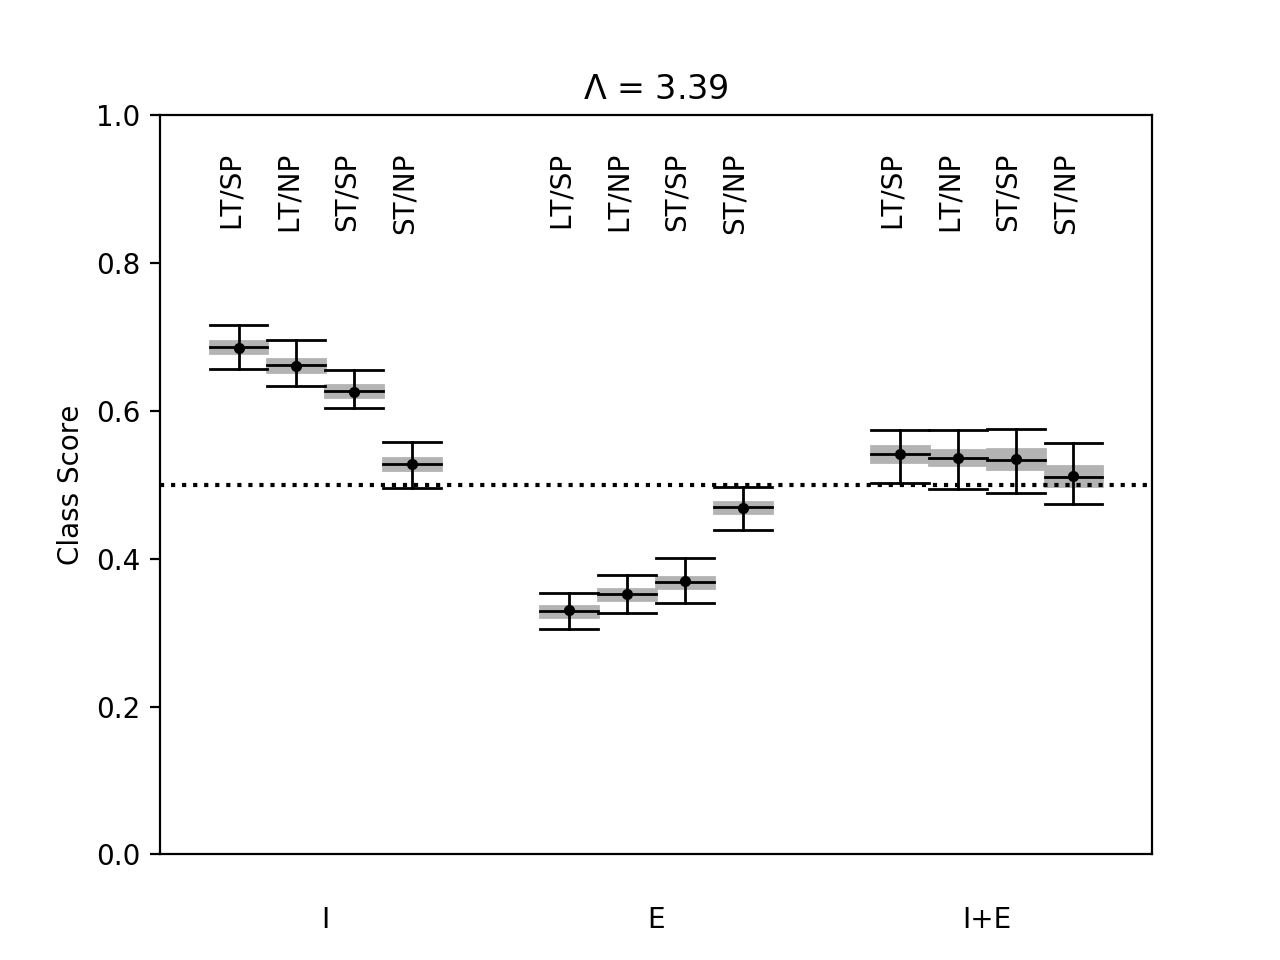

<IPython.core.display.Javascript object>


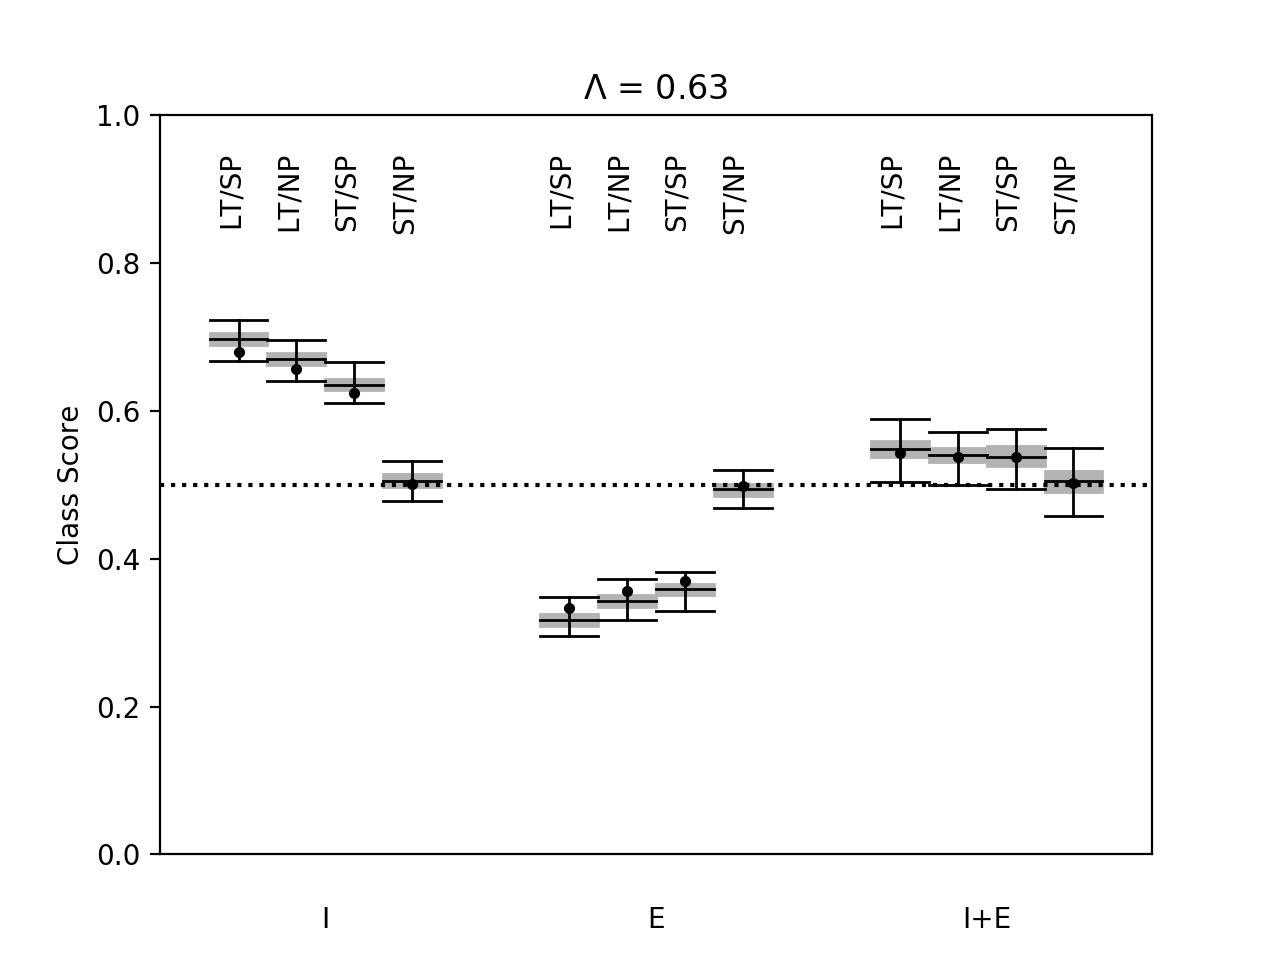

<IPython.core.display.Javascript object>


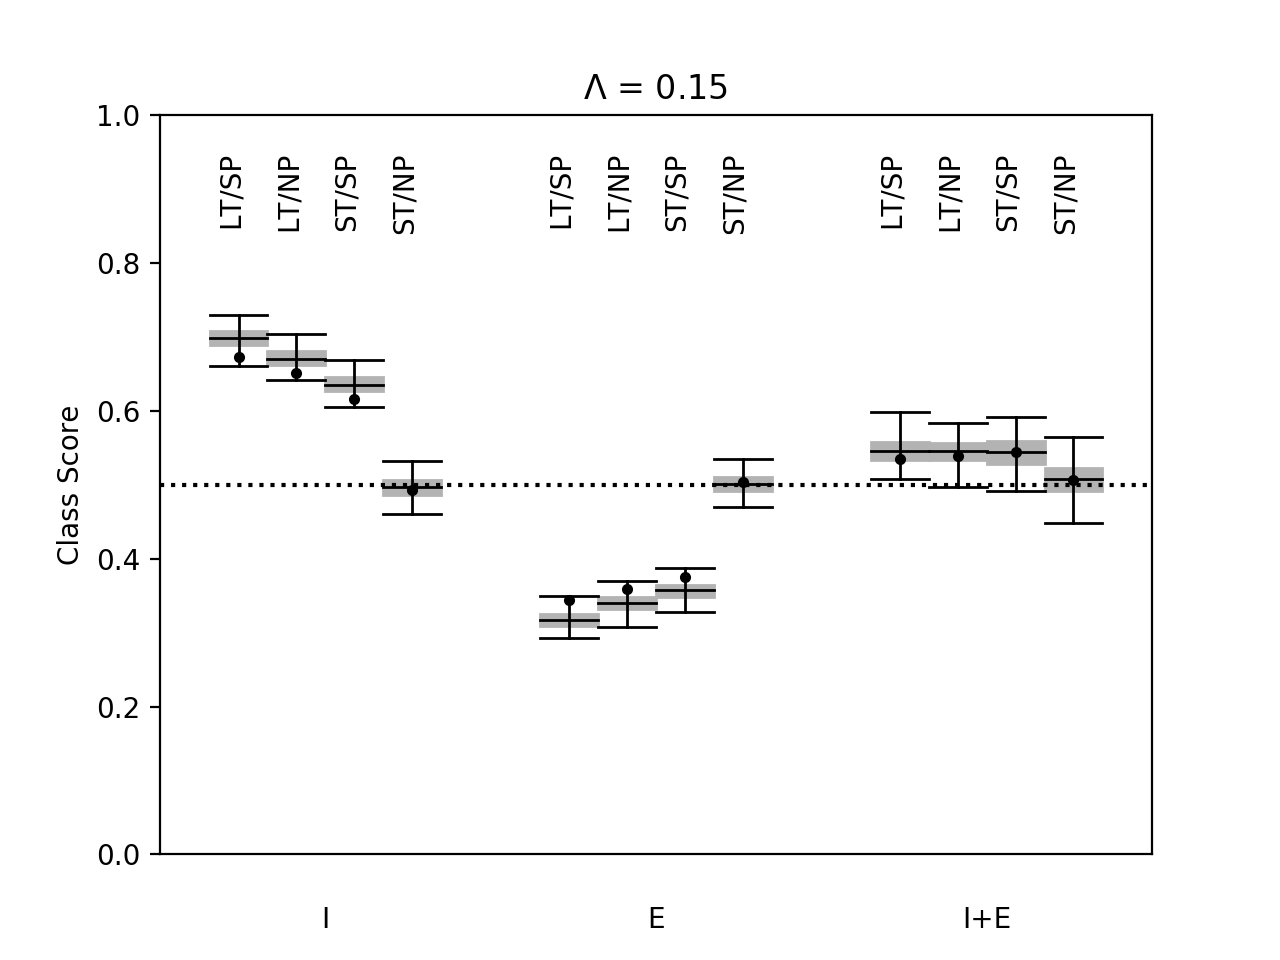

In [21]:
B = 0
for set in sets : 
    for L in set['labels'] : 
        B += 1
        
caption_map = [ '' for b in range(0,B) ]
b = 0
for set in sets : 
    for L in set['labels'] : 
        caption_map[b] = set['capts'][L]
        b += 1
        
plot_data = [ {} for l in lambdas ]
for l in range(0,len(lambdas)) : 
    plot_data[l][ 'I' ] = { 'cntr' : 0 , 
                            'text' : 0-0.025 , 
                            'minr' : np.zeros(b) , 
                            'lowr' : np.zeros(b) , 
                            'medn' : np.zeros(b) , 
                            'mean' : np.zeros(b) , 
                            'actl' : np.zeros(b) , 
                            'uppr' : np.zeros(b) , 
                            'maxr' : np.zeros(b) }
    plot_data[l][ 'E' ] = { 'cntr' : 1 , 
                            'text' : 1-0.025 , 
                            'minr' : np.zeros(b) , 
                            'lowr' : np.zeros(b) , 
                            'medn' : np.zeros(b) , 
                            'mean' : np.zeros(b) , 
                            'actl' : np.zeros(b) , 
                            'uppr' : np.zeros(b) , 
                            'maxr' : np.zeros(b) }
    plot_data[l]['I+E'] = { 'cntr' : 2 , 
                            'text' : 2-0.05 , 
                            'minr' : np.zeros(b) , 
                            'lowr' : np.zeros(b) , 
                            'medn' : np.zeros(b) , 
                            'mean' : np.zeros(b) , 
                            'actl' : np.zeros(b) , 
                            'uppr' : np.zeros(b) , 
                            'maxr' : np.zeros(b) }

C = [ 'I' , 'E' , 'I+E' ]
    
b = 0
for set in sets : 
    
    for L in set['labels'] : 
        
        for c in C : 
            
            actl  = np.fromfile( "%s/actual/%s/class-scores-%s.bin" % (resdir,L,c) ).reshape( (T) )
            score = np.fromfile( "%s/bootstrap/%s/class-scores-%s.bin" % (resdir,L,c) ).reshape( (S,T) )
            
            mean  = np.mean( score , axis=0 )
            medn  = np.median( score , axis=0 )
            ssrt  = np.sort( score , axis=0 )
            lowr  = ssrt[ np.int( np.floor( 0.20*ssrt.shape[0] ) ) , : ]
            uppr  = ssrt[ np.int( np.ceil( 0.80*ssrt.shape[0] ) ) , : ]
            minr  = ssrt[0,:] 
            maxr  = ssrt[-1,:] 
            
            for l in range(0,len(lambdas)) : 
                plot_data[l][c]['minr'][b] = minr[l]
                plot_data[l][c]['lowr'][b] = lowr[l]
                plot_data[l][c]['mean'][b] = mean[l]
                plot_data[l][c]['medn'][b] = medn[l]
                plot_data[l][c]['actl'][b] = actl[l]
                plot_data[l][c]['uppr'][b] = uppr[l]
                plot_data[l][c]['maxr'][b] = maxr[l]
                
        b += 1

w = 0.35
wB = 2.0*w / float(B)

for l in lfix : 
    
    plt.figure()
    
    plt.plot( [-0.5,2.5] , [0.5,0.5] , ':k' )
    
    for c in C :
        
        xl = plot_data[l][c]['cntr'] - w
        for b in range(0,B) : 
            xu = xl + wB
            xc = (xu+xl)/2.0
            plt.plot( [xc,xc] , [plot_data[l][c]['minr'][b],plot_data[l][c]['maxr'][b]] , '-k' , Linewidth=1 )
            
            #for x in [xl,xu] : 
            #    plt.plot( [x,x] , [plot_data[l][c]['lowr'][b],plot_data[l][c]['uppr'][b]] , '-k' , Linewidth=1 )
            #for x in ['minr','lowr','medn','uppr','maxr'] : 
            #    plt.plot( [xl,xu] , [plot_data[l][c][x][b],plot_data[l][c][x][b]] , '-k' , Linewidth=1 )
                
            coords = {   'x' : [ xl , xu , xu , xl ] , 
                         'y' : [ plot_data[l][c]['lowr'][b] , 
                                 plot_data[l][c]['lowr'][b] , 
                                 plot_data[l][c]['uppr'][b] , 
                                 plot_data[l][c]['uppr'][b] ] 
                     }
            plt.fill( coords['x'] , coords['y'] , Color=[0.7,0.7,0.7] )
            for x in ['minr','medn','maxr'] : 
                plt.plot( [xl,xu] , [plot_data[l][c][x][b],plot_data[l][c][x][b]] , '-k' , Linewidth=1 )
                
            plt.plot( xc , plot_data[l][c]['actl'][b] , '.k' )
            
            plt.text( xc , 0.95 , caption_map[b] , rotation=90 , rotation_mode='anchor' , horizontalalignment='right' )
            
            xl = xu
        
        plt.text( plot_data[l][c]['cntr'] , -0.1 , c , horizontalalignment='center' )
    
    f = plt.gca()
    f.axes.xaxis.set_visible(False)
    
    plt.title( "$\Lambda$ = %0.2f" % (lambdas[l]) )
    plt.ylabel( "Class Score" )
    plt.axis( [-0.5,2.5,0.0,1.0] )

        